In [24]:
import uproot
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from scipy.special import eval_chebyt, gamma, factorial
from scipy.stats import argus
from scipy.integrate import quad
from numpy import  log, sqrt, exp, pi, e
import pyroot
import os

In [3]:
gaussian = lambda x, mu, sigma: 1/(sigma*sqrt(2*pi)) * np.exp(-(x-mu)**2/(2*sigma**2))

In [4]:
def nois_log(x, d):
    return np.heaviside(x-d, 1)*np.log(x)

In [5]:
def puasson(x, n):
    return np.exp(-x)*np.power(x, n)/factorial(n)

In [6]:
def normalization(counts, bin_edges):
    total_counts = np.sum(counts)
    bin_width = bin_edges[1] - bin_edges[0]
    return bin_width * total_counts 

In [25]:
def rm(fname):
    if os.path.exists(fname):
        os.remove(fname)
    else:
        print("The file does not exist") 

In [31]:
def max_bin_lik(f, bin_centers, counts, args0, des = False, norm = False, h = 1e-7, bounds = None, normm = None, method='Nelder-Mead'):
    likelihoodn = lambda x, n, norm, *args: np.log(puasson(f(x, *args)/norm, n))
    likelihood = lambda x, n, *args: np.log(puasson(f(x, *args), n))
    if des:
        if norm:
            def df(args0, bin_centers, counts): 
                normf = np.sum(np.array([f(x, *args0) for x in bin_centers])*(bin_centers[1] - bin_centers[0]))
                return -np.sum(np.array([likelihoodn(x, n, normf, *args0) for x, n in zip(bin_centers, counts)]))
        else:
            df = lambda args0, bin_centers, counts: -np.sum(np.array([likelihood(x, n, *args0) for x, n in zip(bin_centers, counts)]))
    else:
        norm = sum(counts)*(bin_centers[1] - bin_centers[0])
        if norm:
            def df (args0, bin_centers, counts):
                normf = np.sum(np.array([f(x, *args0) for x in bin_centers])*(bin_centers[1] - bin_centers[0]))
                return  -np.sum(np.array([likelihoodn(x, n/norm, normf, *args0) for x, n in zip(bin_centers, counts)]))
        else:
            df = lambda args0, bin_centers, counts: -np.sum(np.array([likelihood(x, n/norm, *args0) if n !=0 else 0 for x, n in zip(bin_centers, counts)]))
    rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)
    normf = np.sum(np.array([f(x, *rez.x) for x in bin_centers])*(bin_centers[1] - bin_centers[0]))
    print(rez)
    if normm == None:
        return rez.x, normf
    return rez.x, normf

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2.708507032218605
             x: [ 1.028e+00  8.065e+00  2.017e+00  1.008e+00  7.007e-01]
           nit: 315
          nfev: 518
 final_simplex: (array([[ 1.028e+00,  8.065e+00, ...,  1.008e+00,
                         7.007e-01],
                       [ 1.028e+00,  8.065e+00, ...,  1.008e+00,
                         7.007e-01],
                       ...,
                       [ 1.028e+00,  8.065e+00, ...,  1.008e+00,
                         7.007e-01],
                       [ 1.028e+00,  8.065e+00, ...,  1.008e+00,
                         7.007e-01]]), array([ 2.709e+00,  2.709e+00,  2.709e+00,  2.709e+00,
                        2.709e+00,  2.709e+00]))


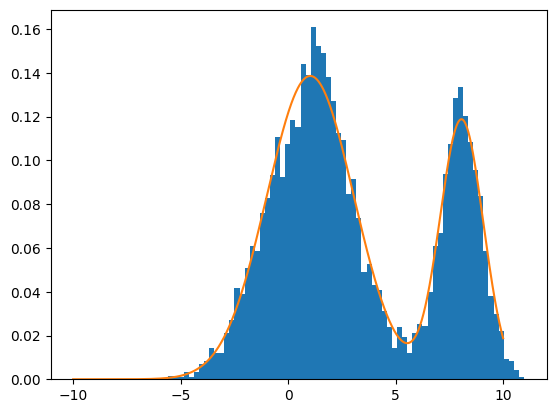

In [32]:
N = 5000
tau = 0.3
x = np.concatenate((np.random.normal(8, 1, int(N*tau)), np.random.normal(1, 2, int(N*(1-tau)))))
plt.hist(x, density=True, bins=70)
counts, bin_edges = np.histogram(x, bins=15)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
f = lambda x, mu1, mu2, s1, s2, tau: gaussian(x, mu1, s1)*tau + gaussian(x, mu2, s2)*(1-tau)
args, _ = max_bin_lik(f, bin_centers, counts, (1, 2, 1, 1, 0.5))
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, [f(i, *args) for i in xx])

In [14]:
lamc_mass = 2.28646
pi_mass = 0.135

In [15]:
fname = "root_/lam_mc.root"
tupl2 = uproot.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
mc = tupl2.arrays(library='pd')

['en', 'nen', 'ecm', 'p', 'np', 'ntr', 'en_gam', 'enc_gam', 'chxc', 'pxc', 'tr_lamc', 'tr_ach', 'tr_p', 'npxc', 'mxc', 'chach', 'mach', 'chl', 'ml', 'pl', 'ang_l_xc', 'nang_l_x', 'ang_lc_l', 'ang_l_p', 'p_prot', 'p_lam', 'rm2n', 'nrm2n', 'rm2l', 'nrm2l', 'pn', 'npn', 'rm2nu', 'nrm2nu', 'fnrm2nu', 'chi', 'q2']


In [16]:
fname = "root_/lam_real.root"
tupl2 = uproot.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
re = tupl2.arrays(library='pd')

['en', 'nen', 'ecm', 'p', 'np', 'ntr', 'en_gam', 'enc_gam', 'chxc', 'pxc', 'npxc', 'mxc', 'chach', 'mach', 'chl', 'ml', 'pl', 'ang_l_xc', 'nang_l_x', 'ang_lc_l', 'ang_l_p', 'p_prot', 'p_lam', 'rm2n', 'nrm2n', 'rm2l', 'nrm2l', 'pn', 'npn', 'rm2nu', 'nrm2nu', 'fnrm2nu', 'chi', 'q2']


In [19]:
data = [re, mc]

In [20]:
mc["chxc"] = pd.to_numeric(mc["chxc"])
mc["chl"] = pd.to_numeric(mc["chl"])


In [21]:
chxc = int(mc.chxc.max()) - 1
decay_mod_taging = ["$X_c \\to D^0 p$", "$X_c \\to D^+ p \\pi^- $", "$X_c \\to D^{*0} p$", "$X_c \\to D^{*+} p \\pi^-$", "$X_c \\to \\Lambda_c^- \\pi^- \\pi^+$"]
decay_mod_tag = {"\\Lambda \\nu_l l": [lambda x: x <= 2, "L_nu_l"], "\\Lambda \\pi" : [lambda x: x == 3, "L_pi"], "p K \\pi" : [lambda x: x == 5, "p_k_pi"]}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0         0.043922
4         0.043922
8         0.043922
12        0.043922
16        0.043922
            ...   
441093   -0.013476
441097   -0.013675
441100   -0.021075
441108    0.021953
441110    0.021953
Name: mach, Length: 58079, dtype: float32
32        0.008240
33        0.049925
45       -0.035398
62        0.008842
73        0.025764
            ...   
441047    0.001221
441049    0.001221
441070   -0.036068
441085    0.006521
441101    0.006353
Name: mach, Length: 56148, dtype: float32
1        -0.008095
2        -0.007943
3        -0.012572
5        -0.008095
6        -0.007943
            ...   
441091    0.010621
441094    0.000077
441098   -0.026791
441099    0.010641
441109   -0.024821
Name: mach, Length: 136204, dtype: float32


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


34        0.001122
46       -0.000117
102      -0.000243
103      -0.000233
134       0.000051
            ...   
441017    0.001029
441084   -0.000019
441102    0.000407
441103    0.000407
441111   -0.000288
Name: mach, Length: 29942, dtype: float32


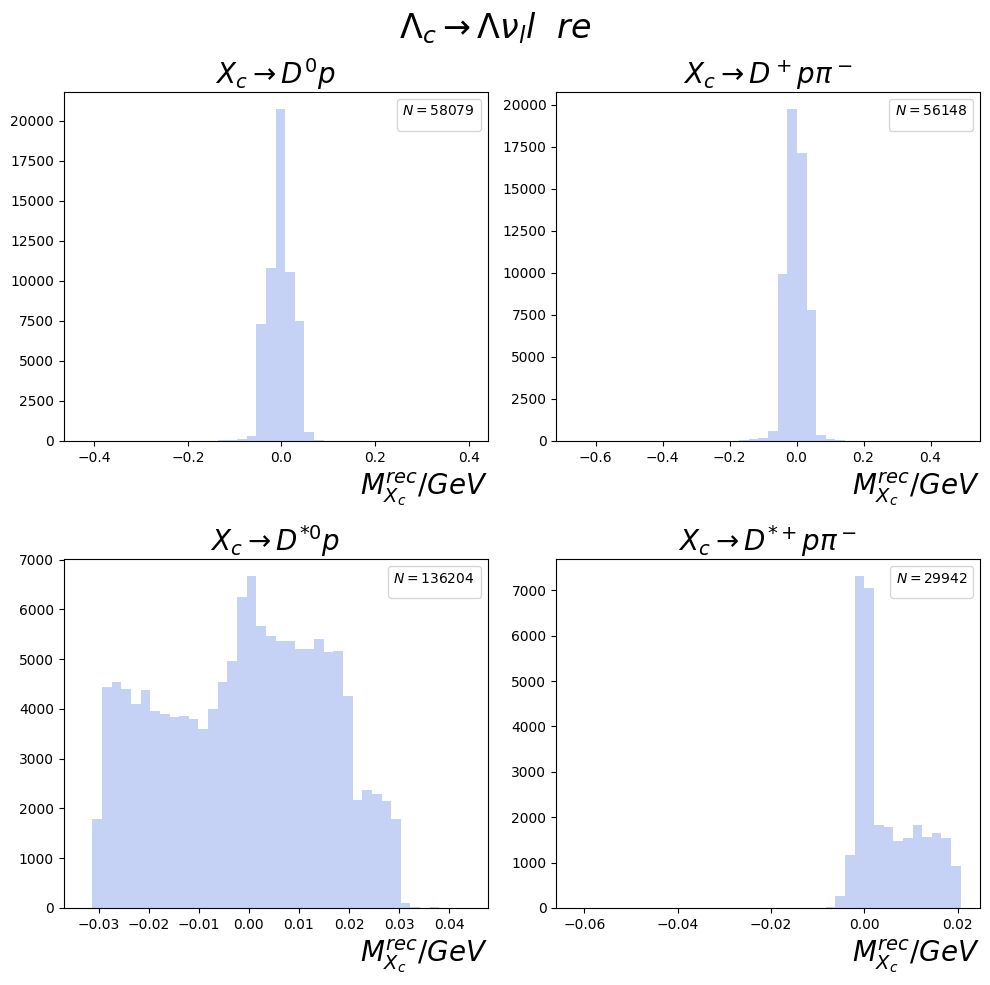

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0         0.043922
4         0.043922
8         0.043922
12        0.043922
16        0.043922
            ...   
441093   -0.013476
441097   -0.013675
441100   -0.021075
441108    0.021953
441110    0.021953
Name: mach, Length: 58079, dtype: float32
32        0.008240
33        0.049925
45       -0.035398
62        0.008842
73        0.025764
            ...   
441047    0.001221
441049    0.001221
441070   -0.036068
441085    0.006521
441101    0.006353
Name: mach, Length: 56148, dtype: float32
1        -0.008095
2        -0.007943
3        -0.012572
5        -0.008095
6        -0.007943
            ...   
441091    0.010621
441094    0.000077
441098   -0.026791
441099    0.010641
441109   -0.024821
Name: mach, Length: 136204, dtype: float32
34        0.001122
46       -0.000117
102      -0.000243
103      -0.000233
134       0.000051
            ...   
441017    0.001029
441084   -0.000019
441102    0.000407
441103    0.000407
441111   -0.000288
Name: mach, Length: 29942, dtype: flo

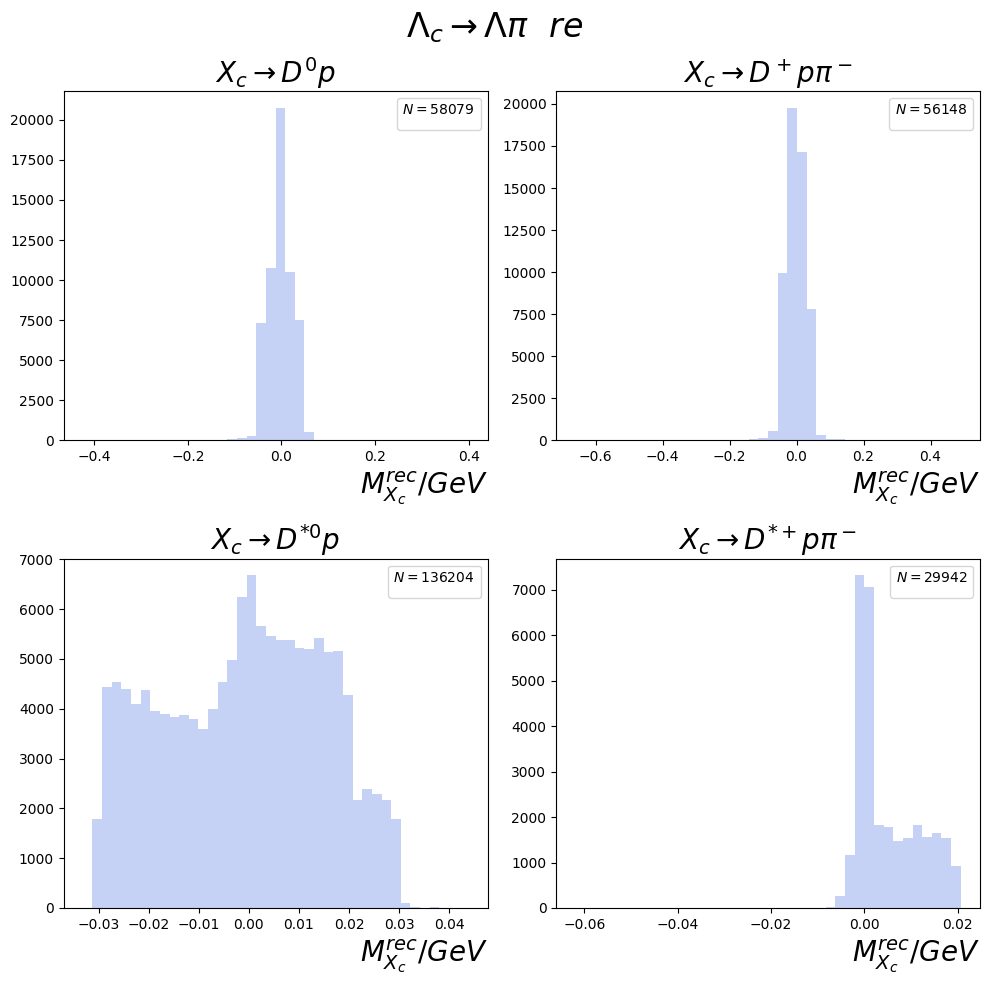

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0         0.043922
4         0.043922
8         0.043922
12        0.043922
16        0.043922
            ...   
441093   -0.013476
441097   -0.013675
441100   -0.021075
441108    0.021953
441110    0.021953
Name: mach, Length: 58079, dtype: float32
32        0.008240
33        0.049925
45       -0.035398
62        0.008842
73        0.025764
            ...   
441047    0.001221
441049    0.001221
441070   -0.036068
441085    0.006521
441101    0.006353
Name: mach, Length: 56148, dtype: float32
1        -0.008095
2        -0.007943
3        -0.012572
5        -0.008095
6        -0.007943
            ...   
441091    0.010621
441094    0.000077
441098   -0.026791
441099    0.010641
441109   -0.024821
Name: mach, Length: 136204, dtype: float32
34        0.001122
46       -0.000117
102      -0.000243
103      -0.000233
134       0.000051
            ...   
441017    0.001029
441084   -0.000019
441102    0.000407
441103    0.000407
441111   -0.000288
Name: mach, Length: 29942, dtype: flo

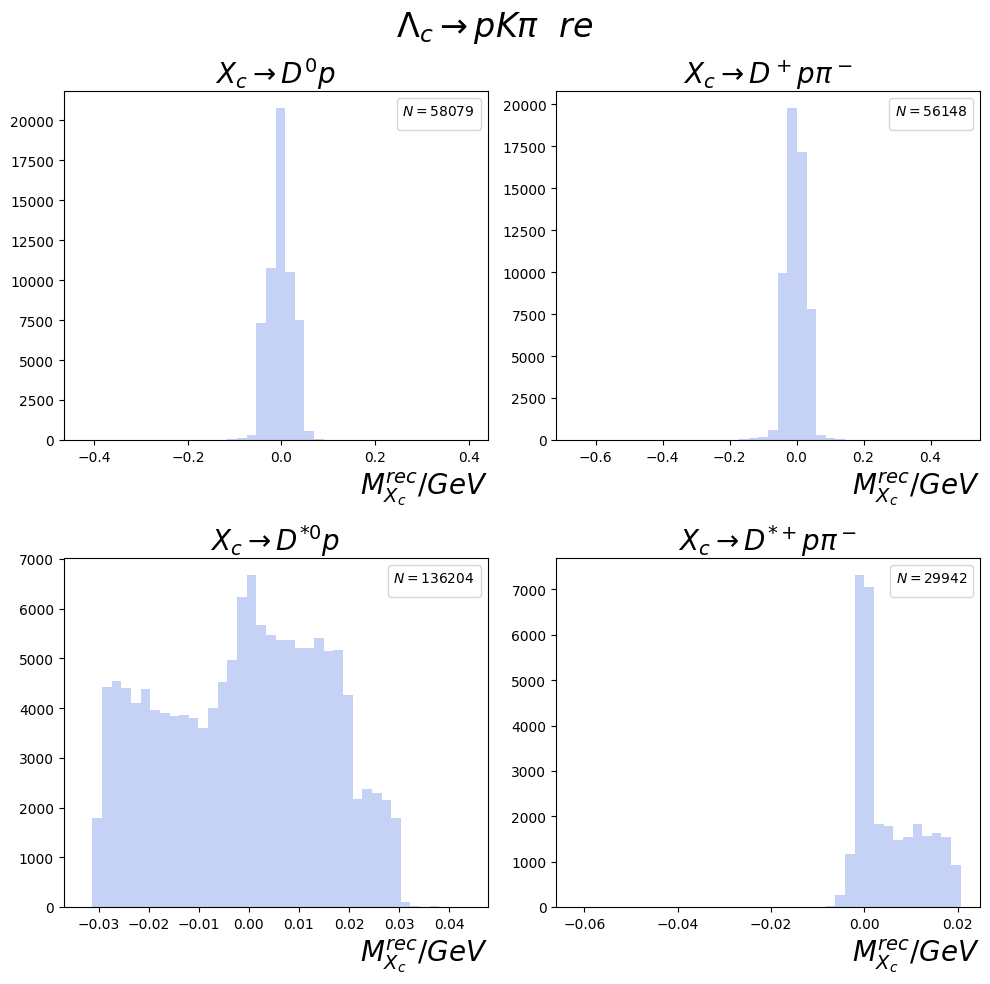

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


29         0.012810
44         0.000001
128       -0.028184
134        0.010926
141        0.000377
             ...   
1135981   -0.001439
1135998    0.029192
1136001    0.007693
1136040   -0.019329
1136047    0.030293
Name: mach, Length: 72781, dtype: float32
31         0.008592
51        -0.005471
52        -0.005471
55        -0.012005
140        0.003717
             ...   
1136020    0.000338
1136030    0.036686
1136043   -0.030869
1136044    0.046510
1136046    0.000637
Name: mach, Length: 102149, dtype: float32
45         0.012784
46        -0.027500
49        -0.039247
50        -0.045429
129       -0.047375
             ...   
1136041    0.017007
1136042   -0.039864
1136045   -0.045118
1136048   -0.032307
1136049   -0.032472
Name: mach, Length: 321993, dtype: float32
0          0.014247
1          0.014247
35        -0.000537
136       -0.000387
160        0.000962
             ...   
1135910    0.000097
1135943    0.006573
1135980    0.000574
1135999   -0.000436
1136039    0

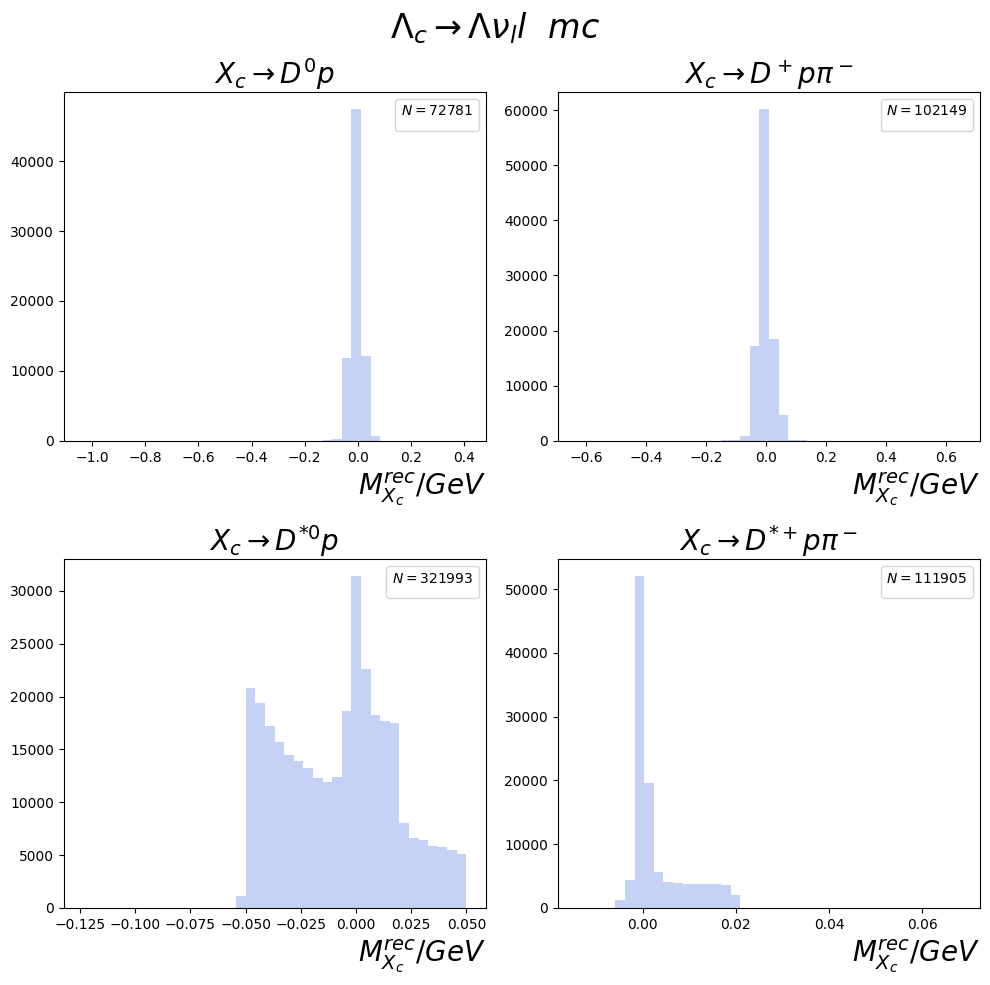

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


29         0.012810
44         0.000001
128       -0.028184
134        0.010926
141        0.000377
             ...   
1135981   -0.001439
1135998    0.029192
1136001    0.007693
1136040   -0.019329
1136047    0.030293
Name: mach, Length: 72781, dtype: float32
31         0.008592
51        -0.005471
52        -0.005471
55        -0.012005
140        0.003717
             ...   
1136020    0.000338
1136030    0.036686
1136043   -0.030869
1136044    0.046510
1136046    0.000637
Name: mach, Length: 102149, dtype: float32
45         0.012784
46        -0.027500
49        -0.039247
50        -0.045429
129       -0.047375
             ...   
1136041    0.017007
1136042   -0.039864
1136045   -0.045118
1136048   -0.032307
1136049   -0.032472
Name: mach, Length: 321993, dtype: float32
0          0.014247
1          0.014247
35        -0.000537
136       -0.000387
160        0.000962
             ...   
1135910    0.000097
1135943    0.006573
1135980    0.000574
1135999   -0.000436
1136039    0

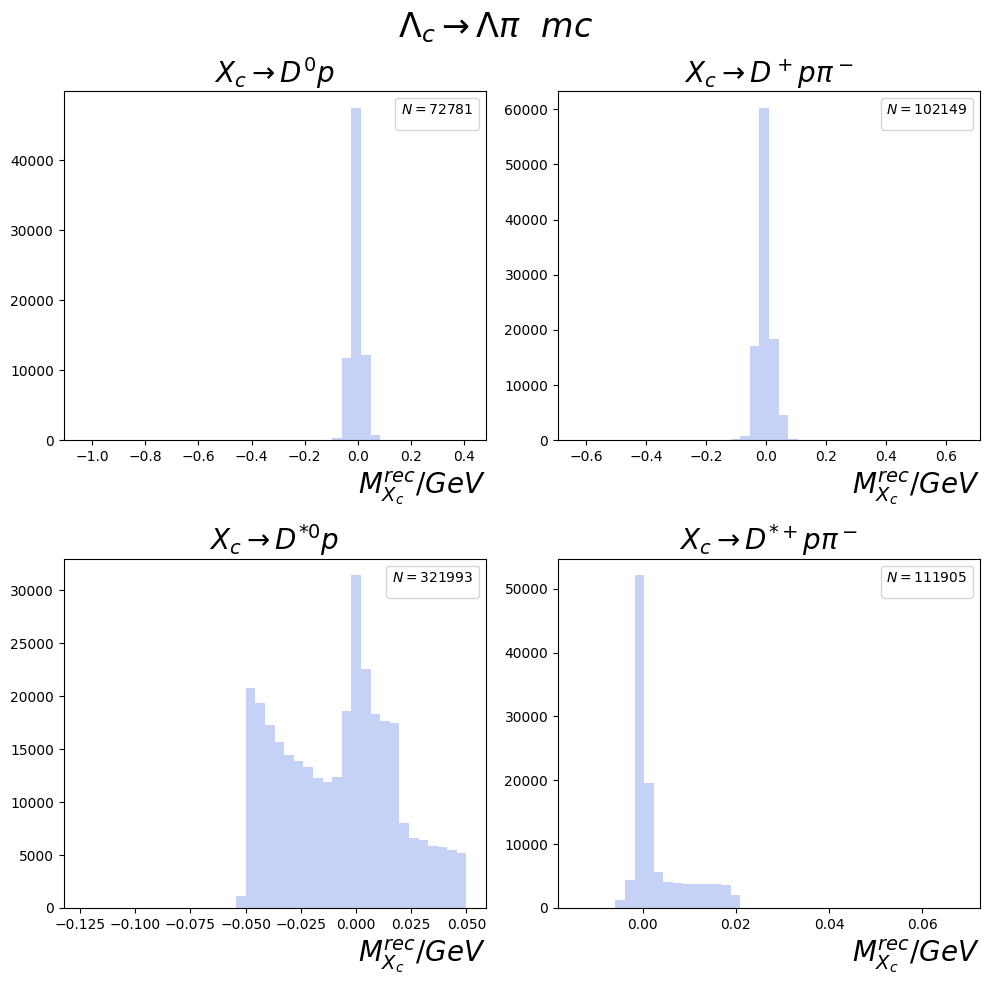

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


29         0.012810
44         0.000001
128       -0.028184
134        0.010926
141        0.000377
             ...   
1135981   -0.001439
1135998    0.029192
1136001    0.007693
1136040   -0.019329
1136047    0.030293
Name: mach, Length: 72781, dtype: float32
31         0.008592
51        -0.005471
52        -0.005471
55        -0.012005
140        0.003717
             ...   
1136020    0.000338
1136030    0.036686
1136043   -0.030869
1136044    0.046510
1136046    0.000637
Name: mach, Length: 102149, dtype: float32
45         0.012784
46        -0.027500
49        -0.039247
50        -0.045429
129       -0.047375
             ...   
1136041    0.017007
1136042   -0.039864
1136045   -0.045118
1136048   -0.032307
1136049   -0.032472
Name: mach, Length: 321993, dtype: float32
0          0.014247
1          0.014247
35        -0.000537
136       -0.000387
160        0.000962
             ...   
1135910    0.000097
1135943    0.006573
1135980    0.000574
1135999   -0.000436
1136039    0

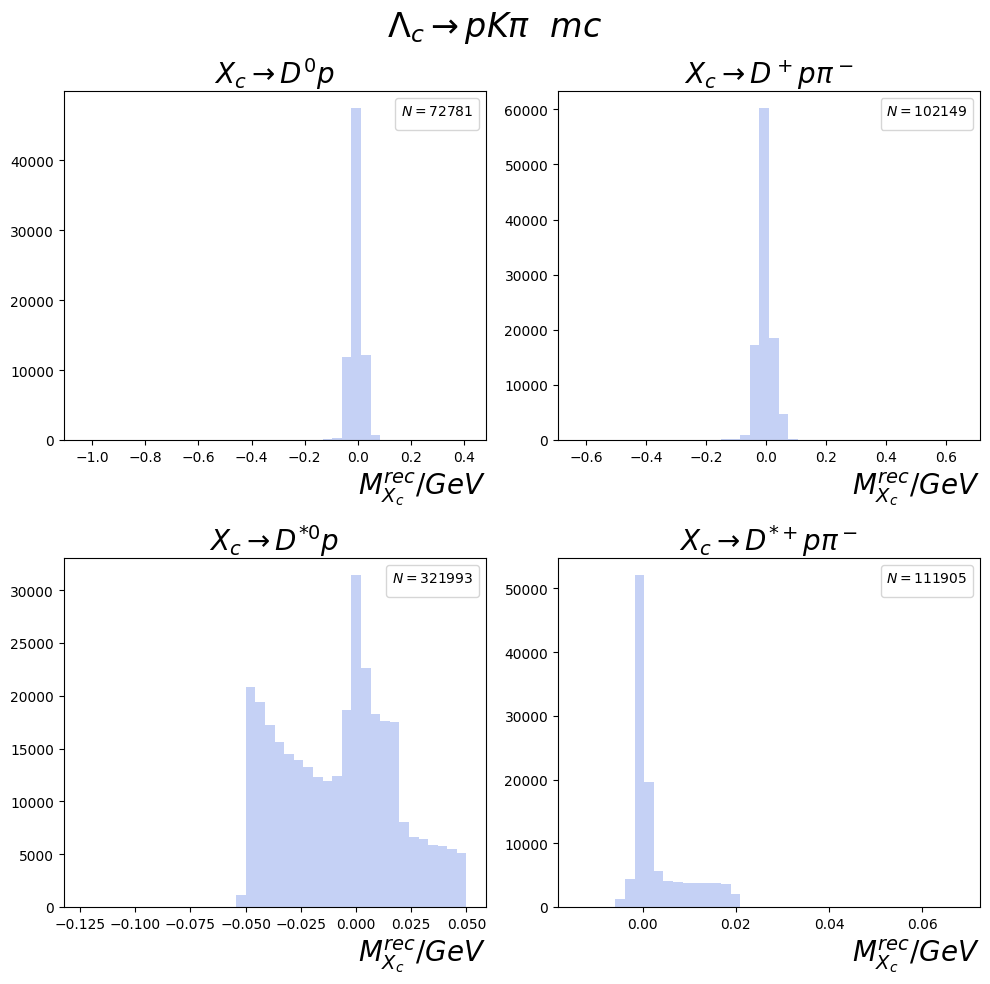

In [38]:
n = int(np.ceil(chxc**0.5))
nbins = 40

for j, dt in enumerate(data):
    for lam_cl, (condition, label) in decay_mod_tag.items():
        fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
        for i in range(chxc):
            if j == 1:
                mask = True
            else:
                mask = True
            if condition(2):
                additional_mask = True
            else:
                additional_mask = True
            dat = dt[(dt.chxc == i + 1) & additional_mask & mask]

            N = dat.shape[0]
            print(dat.mach)
            axs[i//n, i%n].legend(title = f"$N = {N}$")
            axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
            axs[i // n, i % n].hist(dat.mach, bins=nbins, alpha=0.3, color="royalblue")
            #if j == 1:
            #    dat = dt[(dt.chxc == i + 1) &  (condition(dt.chl)) & (abs(lamc_mass - dt.rm2l) <= 0.6) & additional_mask & mask]
            #    axs[i // n, i % n].hist(dat["rm2l"], bins=nbins, alpha=0.3, color="dimgray")
            axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}/GeV$", fontsize=20, loc='right')

        if j == 0:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
            rm(f"..//Lam_c//data//{label}_mc.png")
            fig.savefig(f"..//Lam_c//data//{label}_mc.png")
        else:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
            rm(f"..//Lam_c//data//{label}_re.png")
            fig.savefig(f"..//Lam_c//data//{label}_re.png")
        plt.tight_layout()
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


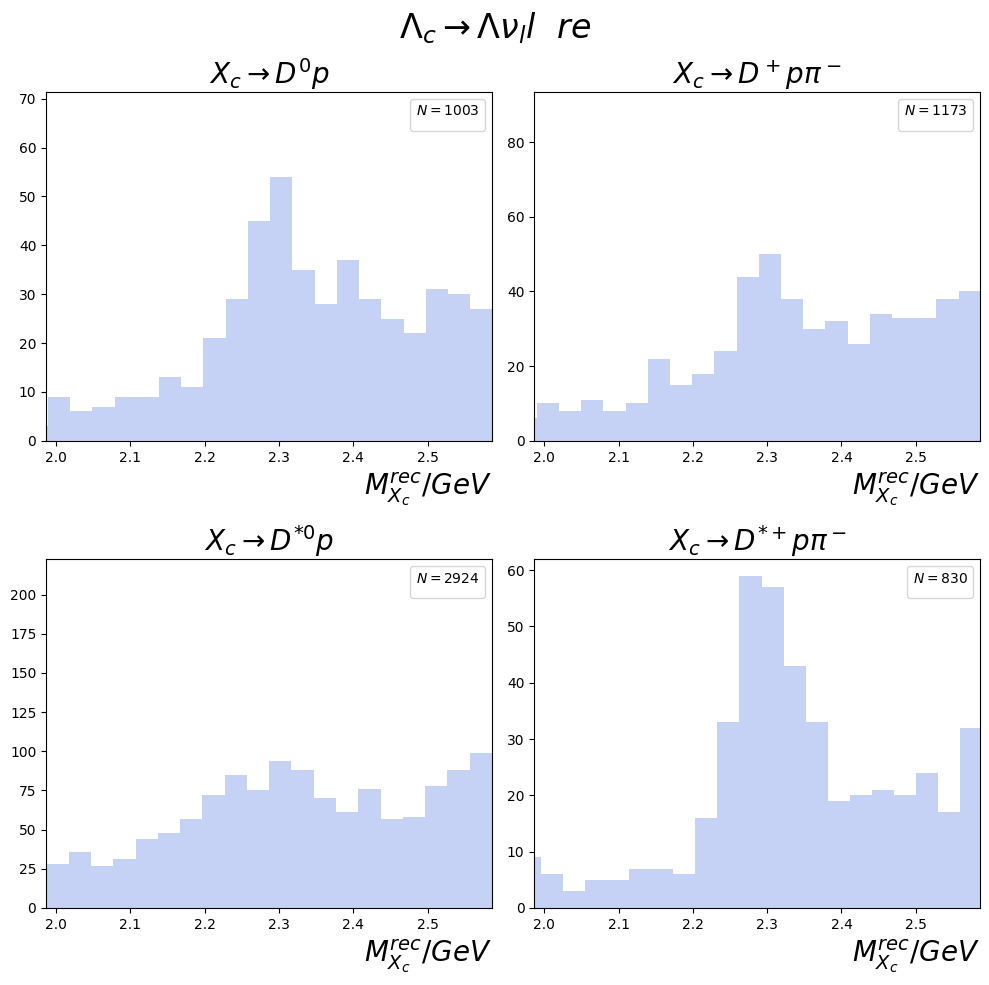

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


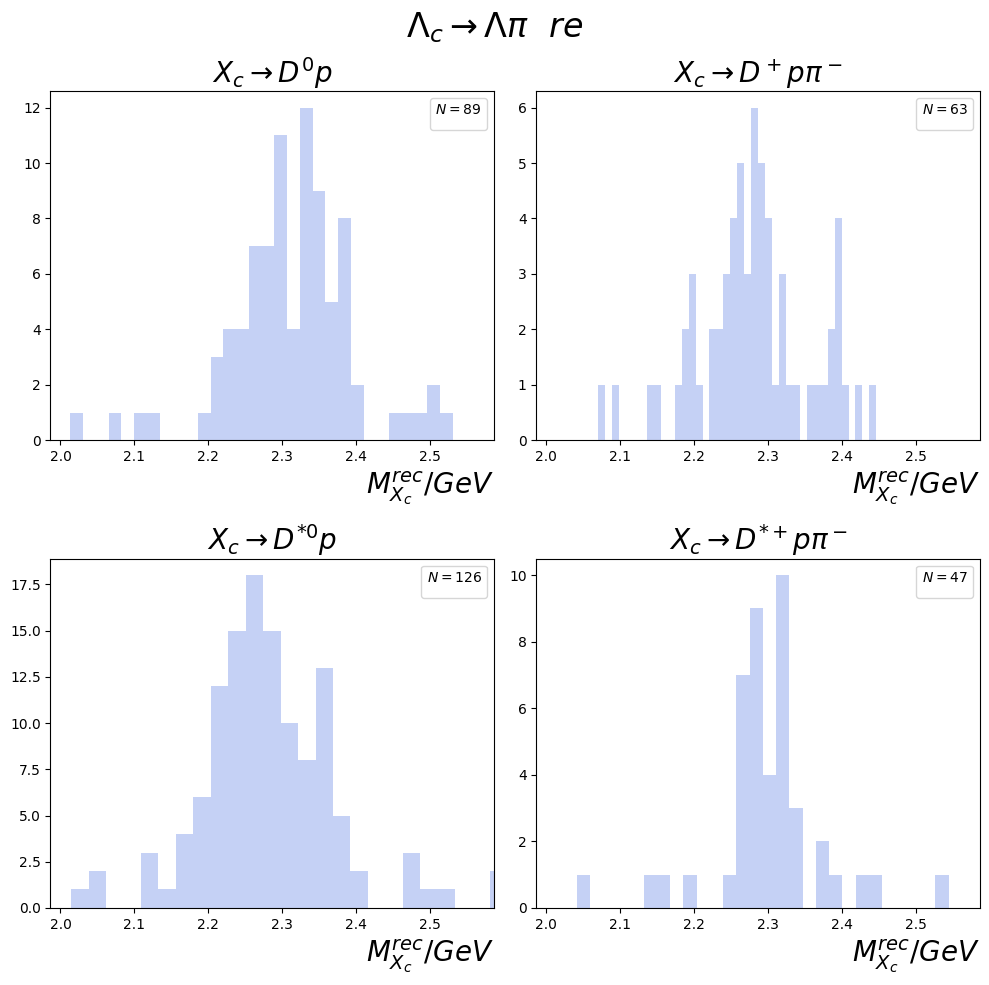

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


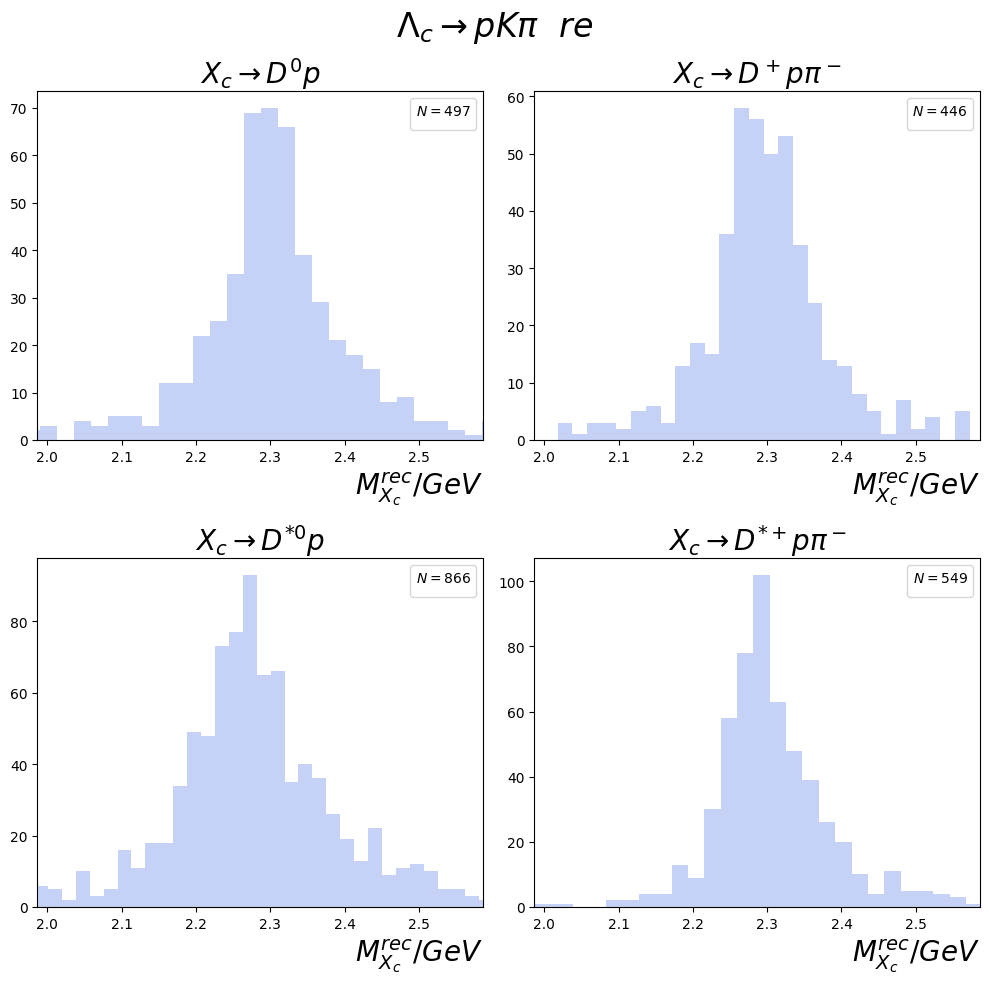

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


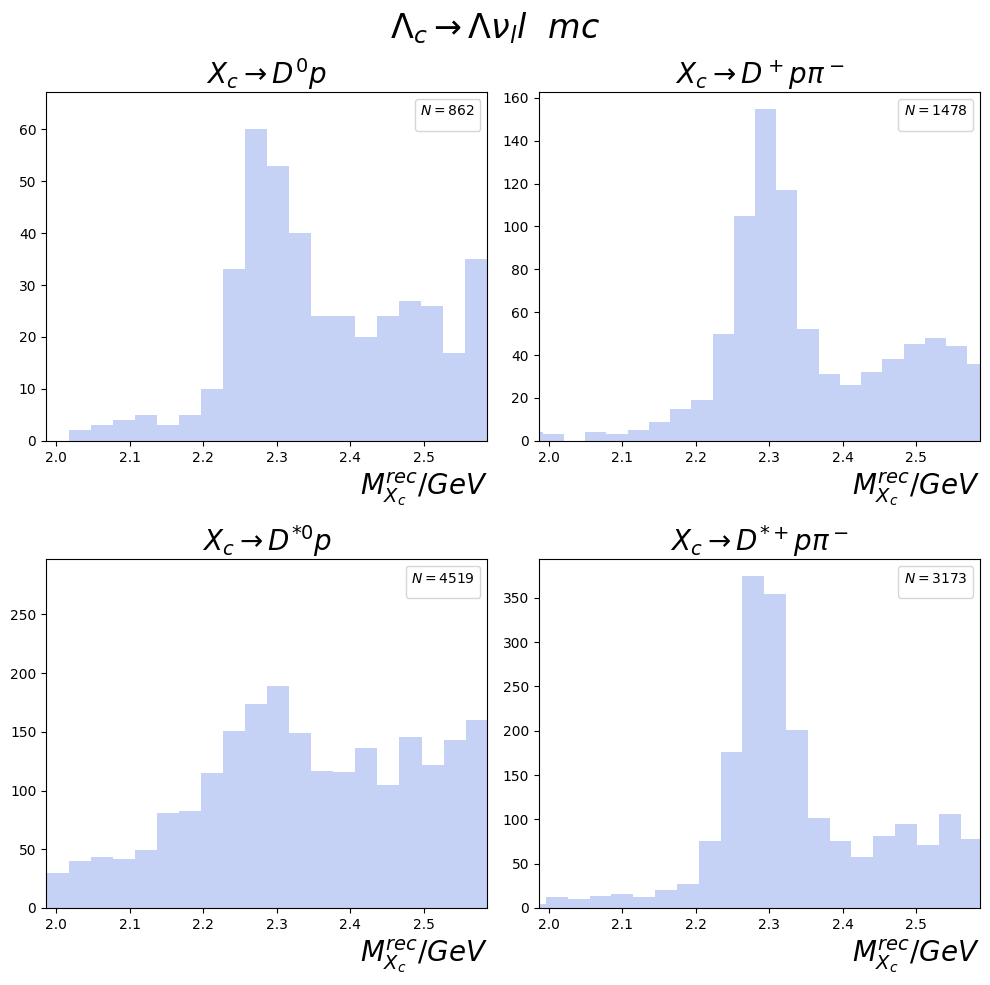

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


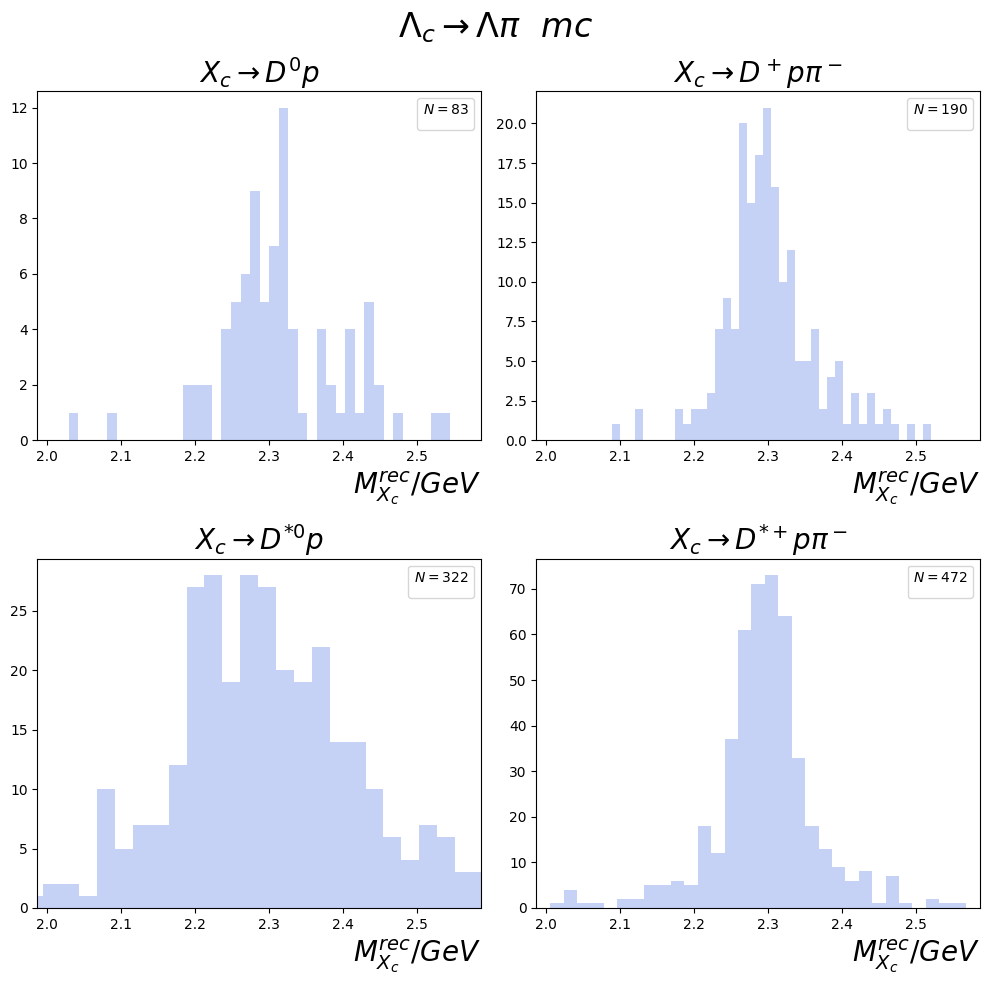

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


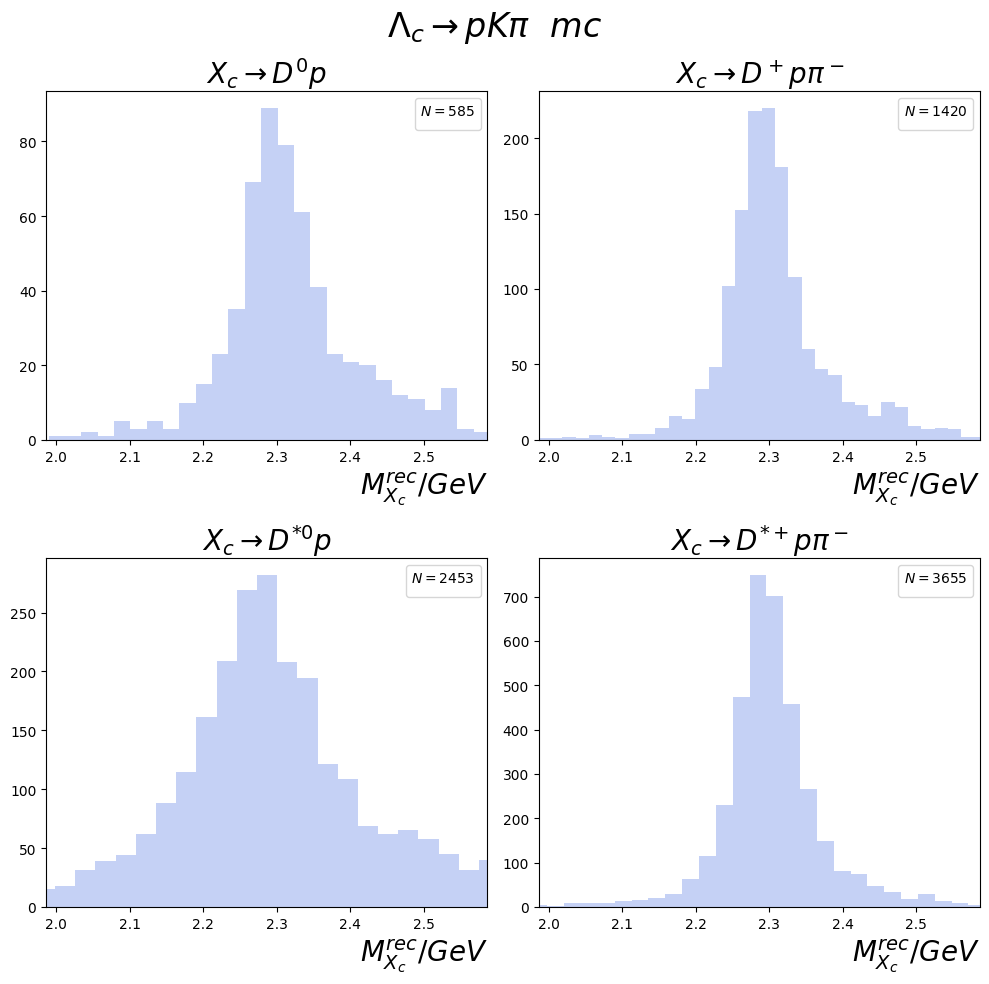

In [29]:
n = int(np.ceil(chxc**0.5))
nbins = 40

for j, dt in enumerate(data):
    for lam_cl, (condition, label) in decay_mod_tag.items():
        fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
        for i in range(chxc):
            if j == 1:
                mask = True
            else:
                mask = True
            if condition(2):
                additional_mask = (dt.nrm2n < 0.05)
            else:
                additional_mask = (abs(dt.en - dt.ecm) < 0.1) & (dt.np < 0.1)
            dat = dt[(dt.chxc == i + 1) &  (condition(dt.chl)) & (abs(lamc_mass - dt.rm2l) <= 0.6) & additional_mask & mask]

            N = dat.shape[0]
            axs[i//n, i%n].legend(title = f"$N = {N}$")
            axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
            axs[i // n, i % n].hist(dat["rm2l"], bins=nbins, alpha=0.3, color="royalblue")
            #if j == 1:
            #    dat = dt[(dt.chxc == i + 1) &  (condition(dt.chl)) & (abs(lamc_mass - dt.rm2l) <= 0.6) & additional_mask & mask]
            #    axs[i // n, i % n].hist(dat["rm2l"], bins=nbins, alpha=0.3, color="dimgray")
            axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}/GeV$", fontsize=20, loc='right')
            axs[i//n, i%n].set_xlim([lamc_mass-0.3, lamc_mass+0.3])

        if j == 0:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
            
            fig.savefig(f"..//Lam_c//data//{label}_mc.png")
        else:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
            fig.savefig(f"..//Lam_c//data//{label}_re.png")
        plt.tight_layout()
        plt.show()

In [61]:
sq = lambda x, c1, c2: c1 * np.sqrt(np.abs(x - pi_mass)) * np.heaviside(x - pi_mass, 0) + c2 * np.sqrt(np.abs(x)) * np.heaviside(x, 0)
continuum_lam = lambda x, A2, sigma1, sigma2, c0, c1, c2: sum(np.array([sq(s, c1, c2)*signal_lam(x-s, A2, sigma1, sigma2) for s in np.linspace(lamc_mass-70*max([sigma1, sigma2]), lamc_mass+70*max([sigma1, sigma2]), 300)]))  + c0*eval_chebyt(0, x)
signal_lam = lambda x, A2, sigma1, sigma2: A2*gaussian(x, lamc_mass, sigma1) + (1-A2)*gaussian(x, lamc_mass, sigma2)
f_lam = lambda x, A1, A2, sigma1, sigma2, c0, c1, c2: A1*signal_lam(x, A2, sigma1, sigma2) + (1-A1)*(continuum_lam(x, A2, sigma1, sigma2, c0, c1, c2))

In [62]:
n = int(np.ceil(chxc**0.5))
nbins = 40
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 1
dt = data[j]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]
with open('res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    mask = (dt.chl <= 2)  & (np.abs(dt.rm2l - lamc_mass) < 0.5) 
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    axs[i//n, i%n].hist(dat.rm2l, bins = nbins, alpha = 0.3, color = "royalblue")
    counts, bin_edges = np.histogram(dat.rm2l, bins=150)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    #args, covar = curve_fit(f_lam, bin_centers, counts/norm, bounds = ([0, 0, -5, -5, -5], [1, 1, 5, 5, 5]))

    if f"fit_{label}_{decay_mod_taging[i]}_{j}" in res:
        args = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"]
    else:
        args = (2.5e-01, 0.5, 1e-01, 1e-01, 1e-01, 5e-01, 5e-01)
#method="SLSQP"
    args, normm = max_bin_lik(f_lam, bin_centers, counts, args, bounds=((0, 1), (0, 1), (0, 0.1), (0, 0.1), (0, 0.4), (0, 1), (0, 1)), method="SLSQP")    
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    #axs[i//n, i%n].plot(x, sq(x, *args[-2:])*norm, label = "approx")
    s1 = args[2]
    s2 = args[3]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2**2*s1**2 + (1-tau2)**2*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i])
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(tau*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")


if j == 0:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"..//Lam_c//data//fit_{label}_mc.png")
    fig.savefig(f"..//Lam_c//data//fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"..//Lam_c//data//{label}_re.png")
    fig.savefig(f"..//Lam_c//data//fit_{label}_re.png")
plt.show()
with open('res.json', 'w') as file:
    json.dump(res, file, indent=4)

/tmp/ipykernel_5766/498977082.py:19: OptimizeWarning: Unknown solver options: xatol, fatol
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)
/tmp/ipykernel_5766/3758858063.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  gaussian = lambda x, mu, sigma: 1/(sigma*sqrt(2*pi)) * np.exp(-(x-mu)**2/(2*sigma**2))
/tmp/ipykernel_5766/3758858063.py:1: RuntimeWarning: invalid value encountered in scalar multiply
  gaussian = lambda x, mu, sigma: 1/(sigma*sqrt(2*pi)) * np.exp(-(x-mu)**2/(2*sigma**2))


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 131.6321114523726
       x: [ 5.352e-01  3.718e-01  1.000e-01  3.494e-02  3.298e-01
            3.002e-01  3.313e-01]
     nit: 11
     jac: [-2.670e-04 -1.526e-04 -5.106e+00 -6.748e-03 -3.033e-04
            2.861e-04  2.384e-04]
    nfev: 97
    njev: 11
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 128.0965832516248
       x: [ 5.304e-01  4.701e-01  6.708e-02  2.664e-02  3.059e-01
            6.997e-02  2.061e-01]
     nit: 15
     jac: [-9.279e-03  8.297e-04  9.066e+00  5.966e-03  1.392e-04
            7.765e-03  8.371e-03]
    nfev: 144
    njev: 15
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 138.5885625460698
       x: [ 2.975e-01  0.000e+00  9.731e-02  9.736e-02  3.244e-01
            2.273e-01  0.000e+00]
     nit: 12
     jac: [ 2.129e-02  2.537e-04 -3.338e-04  1.350e-01  4.902e-04
           -2.028e-02  3.081e-01]
  

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


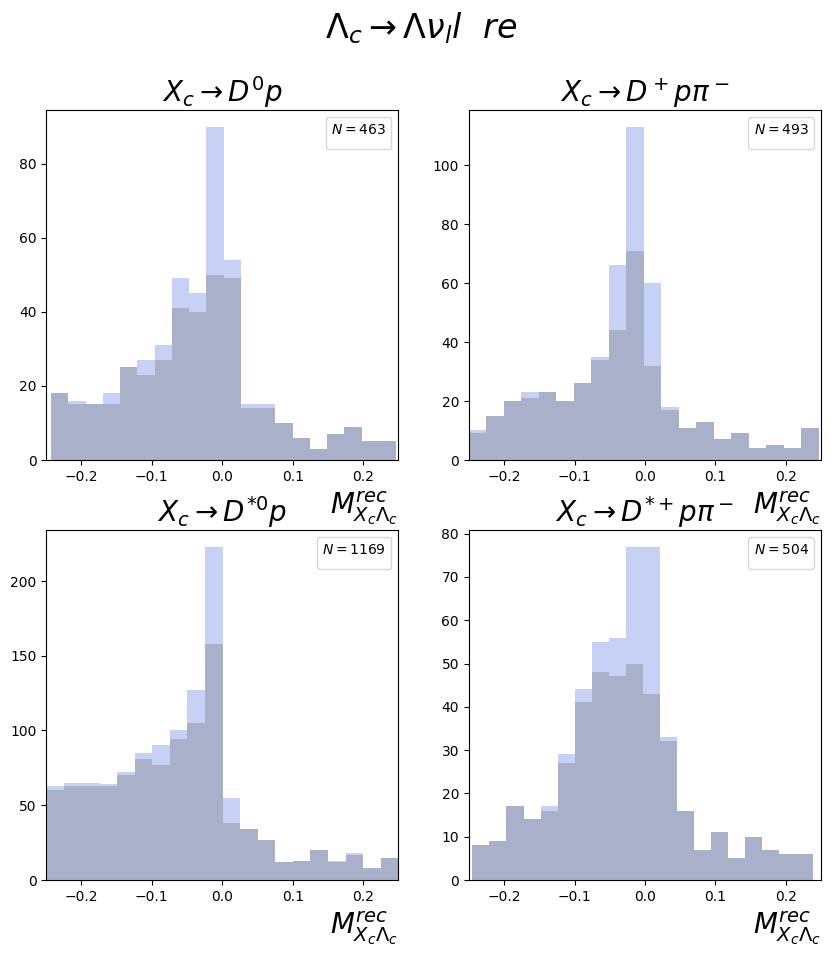

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


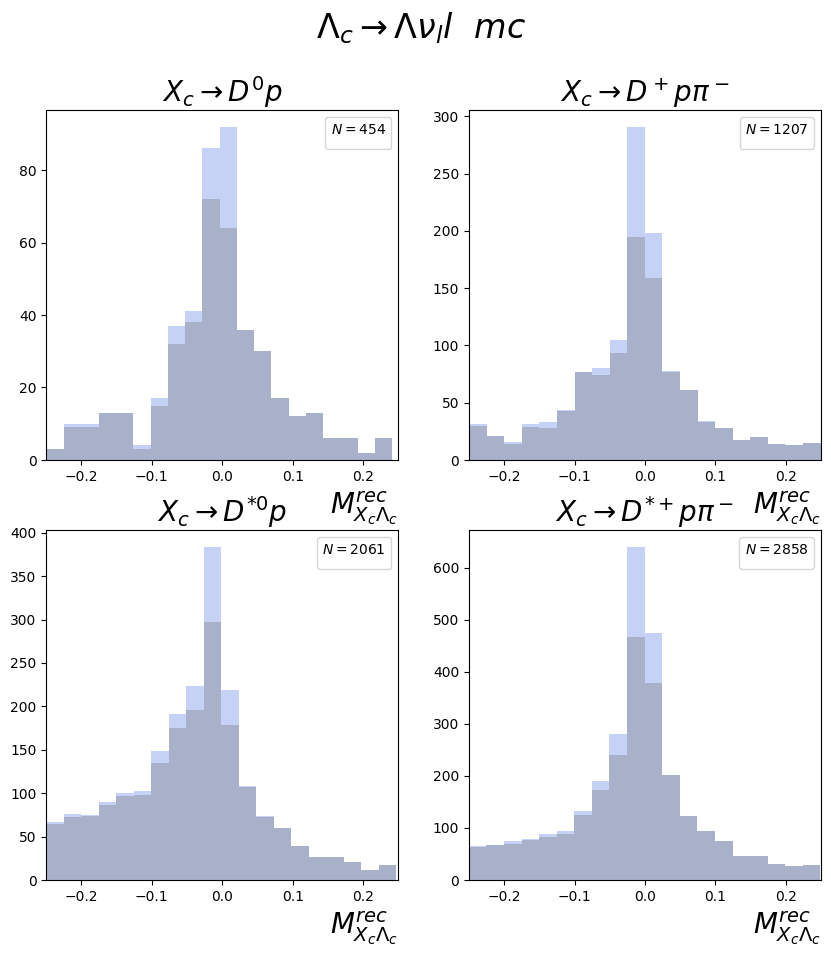

In [339]:
n = int(np.ceil(chxc**0.5))
nbins = 20

for j, dt in enumerate(data):
        lam_cl = "\\Lambda \\nu_l l"
        condition, label = decay_mod_tag[lam_cl]
        fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
        for i in range(chxc):
            dat = dt[(dt.chxc == i + 1) & (abs(dt.rm2n) < 0.25) & (abs(lamc_mass - dt.rm2l) < 0.1) & ((dt.ecm - dt.en) > 0.05) & (dt.p>0.05) & (dt.q2 < 1.37) & (dt.q2 > 0)]
            N = dat.shape[0]
            axs[i//n, i%n].legend(title = f"$N = {N}$")
            axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
            axs[i // n, i % n].hist(dat.rm2n, bins=nbins, alpha=0.3, color="royalblue")
            dat = dt[(dt.chxc == i + 1) & (abs(dt.rm2n) < 0.25) & (abs(lamc_mass - dt.rm2l) < 0.1) & ((dt.ecm - dt.en) > 0.1) & (dt.p>0.1) & (dt.q2 < 1.37) & (dt.q2 > 0)]
            axs[i // n, i % n].hist(dat.rm2n, bins=nbins, alpha=0.3, color="dimgray")
            axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c \\Lambda_c }$", fontsize=20, loc='right')
            axs[i//n, i%n].set_xlim([-0.25, 0.25])

        if j == 0:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
            fig.savefig(f"..//Lam_c//data//priv_10_{label}_mc.png")
        else:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
            fig.savefig(f"..//Lam_c//data//priv_10_{label}_re.png")

        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


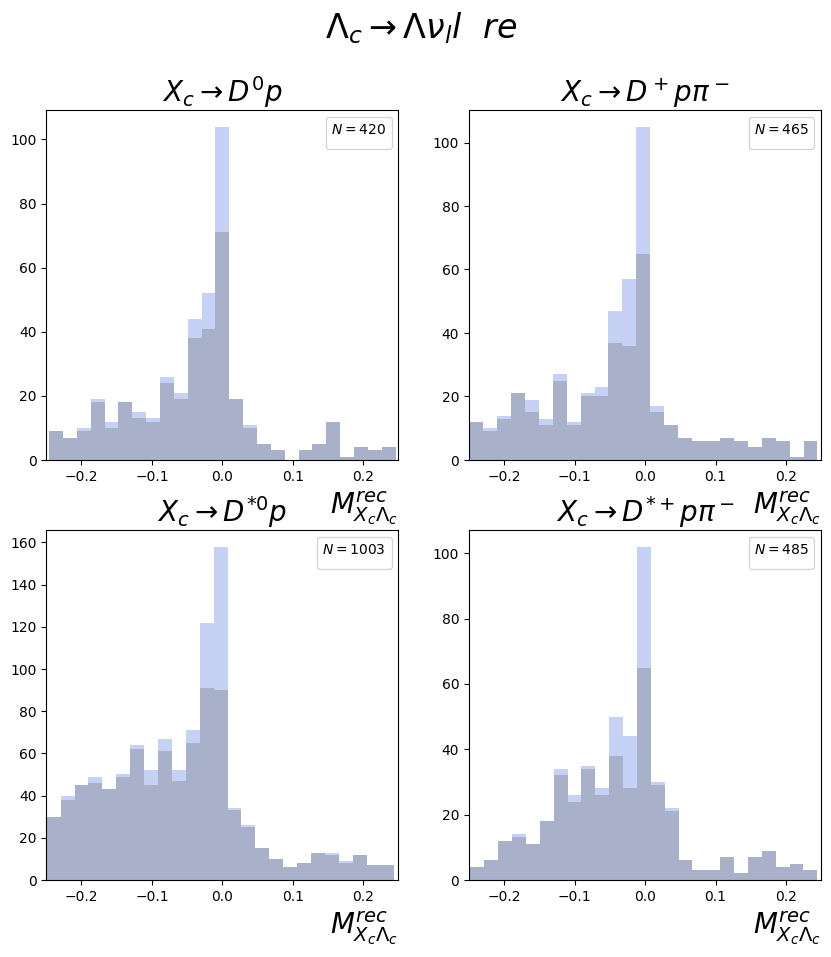

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


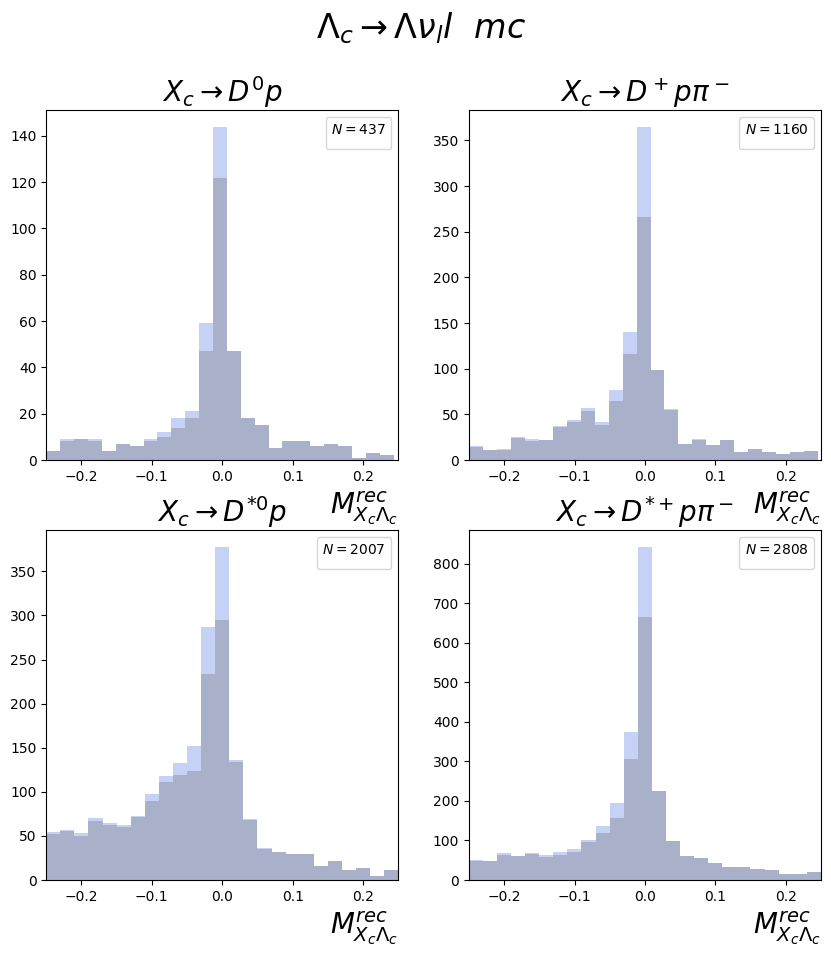

In [340]:
n = int(np.ceil(chxc**0.5))
nbins = 25

for j, dt in enumerate(data):
        lam_cl = "\\Lambda \\nu_l l"
        condition, label = decay_mod_tag[lam_cl]
        fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
        for i in range(chxc):
            dat = dt[(dt.chxc == i + 1) & (abs(dt.nrm2n) < 0.25) & (abs(lamc_mass - dt.rm2l) < 0.1) & ((dt.ecm - dt.nen) > 0.05) & (dt.np>0.05) & (dt.q2 < 1.37) & (dt.q2 > 0)]
            N = dat.shape[0]
            axs[i//n, i%n].legend(title = f"$N = {N}$")
            axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
            axs[i // n, i % n].hist(dat.nrm2n, bins=nbins, alpha=0.3, color="royalblue")
            dat = dt[(dt.chxc == i + 1) & (abs(dt.nrm2n) < 0.25) & (abs(lamc_mass - dt.rm2l) < 0.1) & ((dt.ecm - dt.nen) > 0.1) & (dt.np>0.1) & (dt.q2 < 1.37) & (dt.q2 > 0)]
            axs[i // n, i % n].hist(dat.nrm2n, bins=nbins, alpha=0.3, color="dimgray")
            axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c \\Lambda_c}$", fontsize=20, loc='right')
            axs[i//n, i%n].set_xlim([-0.25, 0.25])

        if j == 0:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
            fig.savefig(f"..//Lam_c//data//priv_10_{label}_mc_f.png")
        else:
            fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
            fig.savefig(f"..//Lam_c//data//priv_10_{label}_re_f.png")

        plt.show()

/tmp/ipykernel_4773/498977082.py:19: OptimizeWarning: Initial guess is not within the specified bounds
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)


TypeError: <lambda>() takes 5 positional arguments but 6 were given

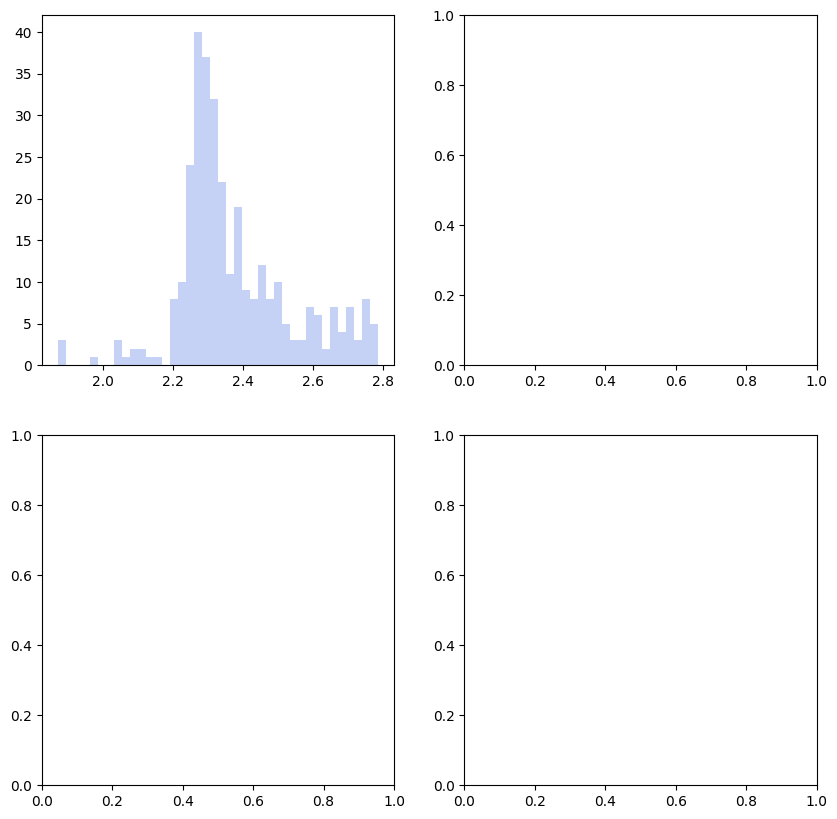

In [211]:
n = int(np.ceil(chxc**0.5))
nbins = 50
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 0
dt = data[0]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]
with open('res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    mask = (dt.chl <= 2)  & (np.abs(dt.rm2l - lamc_mass) < 0.5) & ()
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    axs[i//n, i%n].hist(dat.rm2l, bins = nbins, alpha = 0.3, color = "royalblue")
    counts, bin_edges = np.histogram(dat.rm2l, bins=150)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    #args, covar = curve_fit(f_lam, bin_centers, counts/norm, bounds = ([0, 0, -5, -5, -5], [1, 1, 5, 5, 5]))

    if f"fit_{label}_{decay_mod_taging[i]}_{j}" in res:
        args = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"]
    else:
        args = (2.5e-01, 8e-02, 1e-01, 5e-01)

    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[-3:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    #axs[i//n, i%n].plot(x, sq(x, *args[-2:])*norm, label = "approx")
    sigmas_12.append(round(float(np.abs(args[1])), 6))

    axs[i//n, i%n].set_title(decay_mod_taging[i])
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()

    if j == 0:
        fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
        fig.savefig(f"..//Lam_c//data//_{label}_mc.png")
    else:
        fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
        fig.savefig(f"..//Lam_c//data//ang_{label}_re.png")

plt.show()


/tmp/ipykernel_22192/2666230078.py:19: OptimizeWarning: Initial guess is not within the specified bounds
  rez = minimize(df, args0, args=(bin_centers, counts), method='Nelder-Mead', options={'xatol': h, 'fatol': h}, bounds=bounds)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 74.3819686286562
             x: [ 1.792e-03  3.433e-02  1.548e-02  2.162e-02  2.371e+00]
           nit: 331
          nfev: 564
 final_simplex: (array([[ 1.792e-03,  3.433e-02, ...,  2.162e-02,
                         2.371e+00],
                       [ 1.792e-03,  3.433e-02, ...,  2.162e-02,
                         2.371e+00],
                       ...,
                       [ 1.792e-03,  3.433e-02, ...,  2.162e-02,
                         2.371e+00],
                       [ 1.792e-03,  3.433e-02, ...,  2.162e-02,
                         2.371e+00]]), array([ 7.438e+01,  7.438e+01,  7.438e+01,  7.438e+01,
                        7.438e+01,  7.438e+01]))


/tmp/ipykernel_22192/84174007.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-x)*np.power(x, n)/gamma(n)


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 83.9723732758508
             x: [ 1.879e-03  4.240e-02  4.492e-03  2.133e-02  2.371e+00]
           nit: 231
          nfev: 406
 final_simplex: (array([[ 1.879e-03,  4.240e-02, ...,  2.133e-02,
                         2.371e+00],
                       [ 1.879e-03,  4.240e-02, ...,  2.133e-02,
                         2.371e+00],
                       ...,
                       [ 1.879e-03,  4.240e-02, ...,  2.133e-02,
                         2.371e+00],
                       [ 1.879e-03,  4.240e-02, ...,  2.133e-02,
                         2.371e+00]]), array([ 8.397e+01,  8.397e+01,  8.397e+01,  8.397e+01,
                        8.397e+01,  8.397e+01]))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 126.6384637090623
             x: [ 7.999e-02  1.076e-01  9.565e-02  1.069e+00  2.371e+00]
           nit: 46

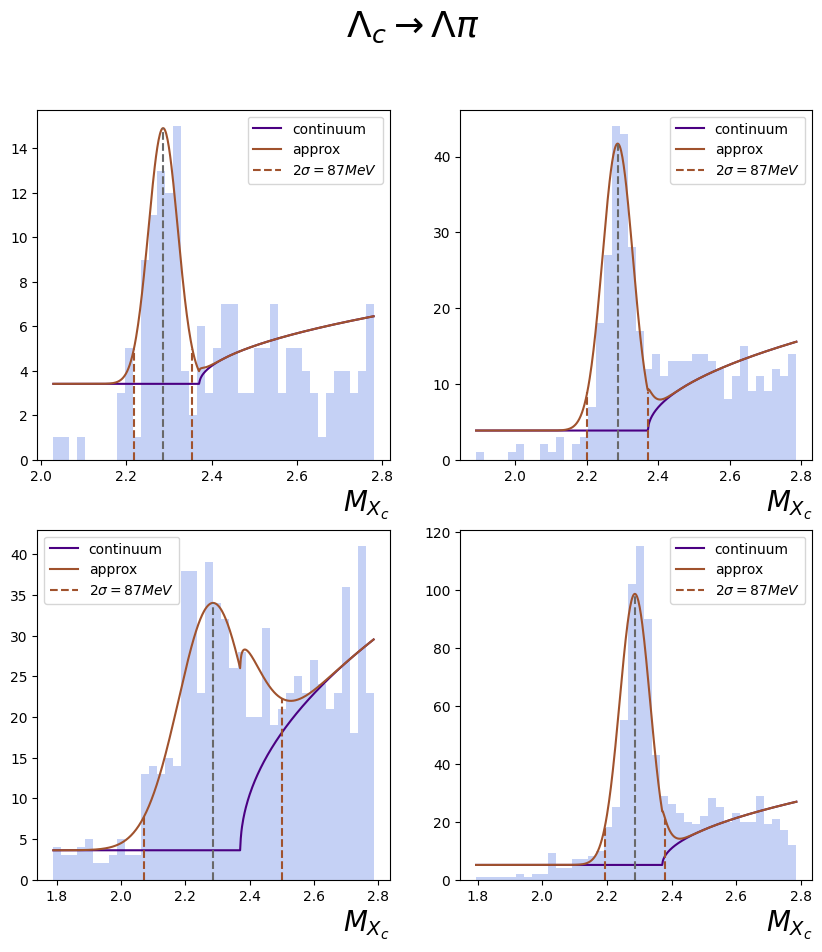

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 40
sigmas_3 = list()

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl == 3)  & (np.abs(mc.rm2l - lamc_mass) < 0.5) & (np.abs(mc.nrm2n) < 0.1) 
    dat = mc[(mc.chxc == i + 1) & (np.abs(mc.nrm2n) < 5) & (abs(mc.nrm2l-lamc_mass) < 0.5) & mask]

    norm = dat.rm2l.shape[0]/nbins
    axs[i//n, i%n].hist(dat.rm2l, bins = nbins, alpha = 0.3, color = "royalblue")
    counts, bin_edges = np.histogram(dat.rm2l, bins=100)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 500)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    #args, covar = curve_fit(f_lam, bin_centers, counts/norm, bounds = ([0, 0, -5, -5, -5], [1, 1, 5, 5, 5]))

    args, normm = max_bin_lik(f_lam, bin_centers, counts, (0.5, 0.15, 0, 1, lamc_mass + pi_mass), bounds=((0, 1), (0, 0.2), (0, 0.1), (-2, 2), (lamc_mass + pi_mass-0.05, lamc_mass + pi_mass-0.05)))    
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[-3:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    #axs[i//n, i%n].plot(x, sq(x, *args[-2:])*norm, label = "approx")
    sigmas_3.append(round(float(np.abs(args[1])), 6))


    axs[i//n, i%n].vlines((lamc_mass-2*np.abs(args[1]),lamc_mass+2*np.abs(args[1])), (0, 0), 
                          (f_lam(lamc_mass-2*np.abs(args[1]), *args)*norm/normm, f_lam(lamc_mass+2*np.abs(args[1]), *args)*norm/normm), 
                          linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()

fig.suptitle("$\\Lambda_c \\to \\Lambda \\pi $", fontsize = 26)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fiting_ml_pkpi.png")

<>:16: SyntaxWarning: invalid escape sequence '\L'
<>:16: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_6714/2074193042.py:16: SyntaxWarning: invalid escape sequence '\L'
  fig.suptitle("$\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when l

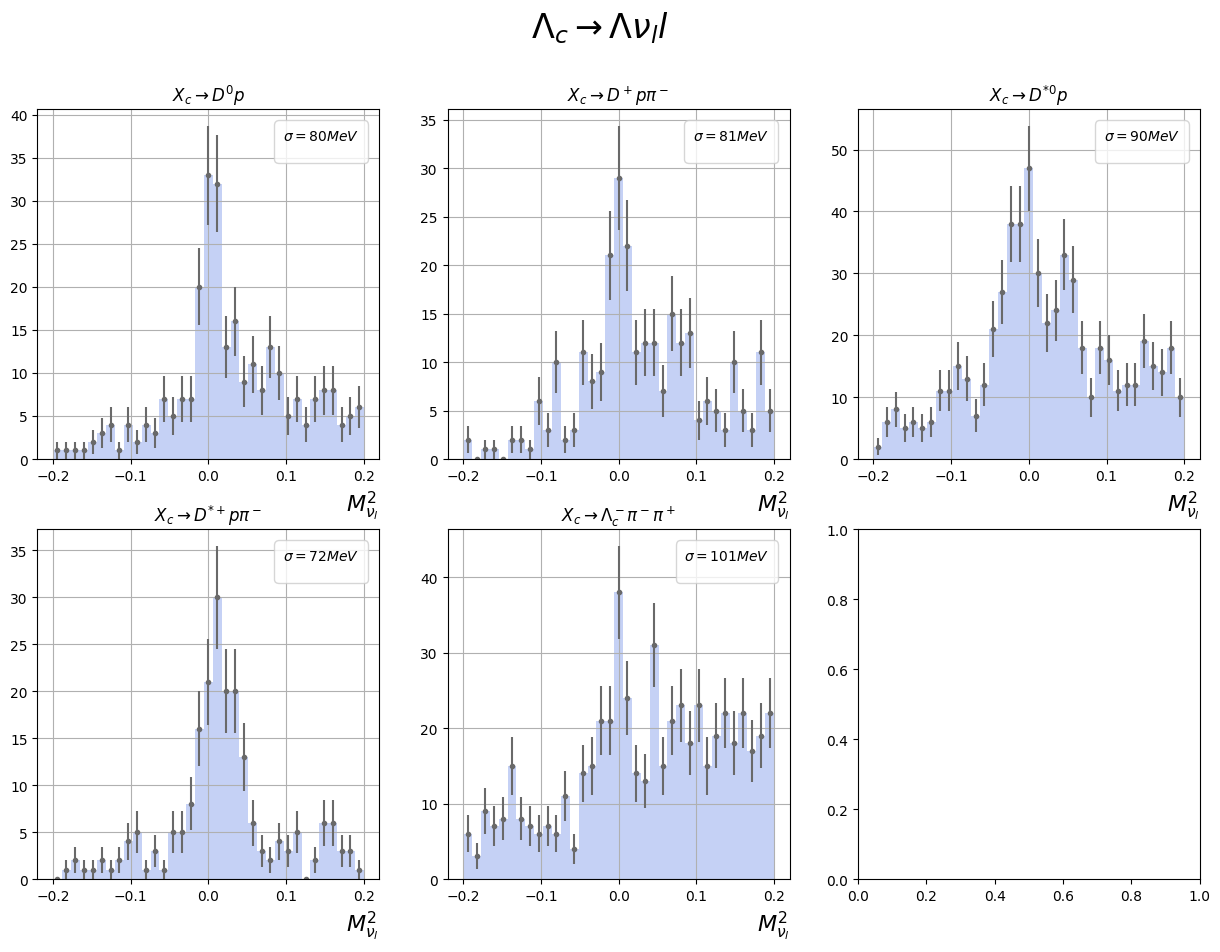

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 35

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) & (np.abs(mc.rm2n) < 0.2)
    counts, bin_edges, _ = axs[i//n, i%n].hist(mc[(mc.chxc == i + 1) & mask].rm2n, bins = nbins, range = (-0.2, +0.2), alpha = 0.3, color = "royalblue")
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
    axs[i//n, i%n].set_title(decay_mod_taging[i])
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')  
    axs[i//n, i%n].legend(title=f'$\\sigma = {round(float(np.var(mc[(mc.chxc == i + 1) & mask].rm2n)**0.5*1000))} MeV$', fontsize=16)

fig.suptitle("$\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fit_w_bef.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


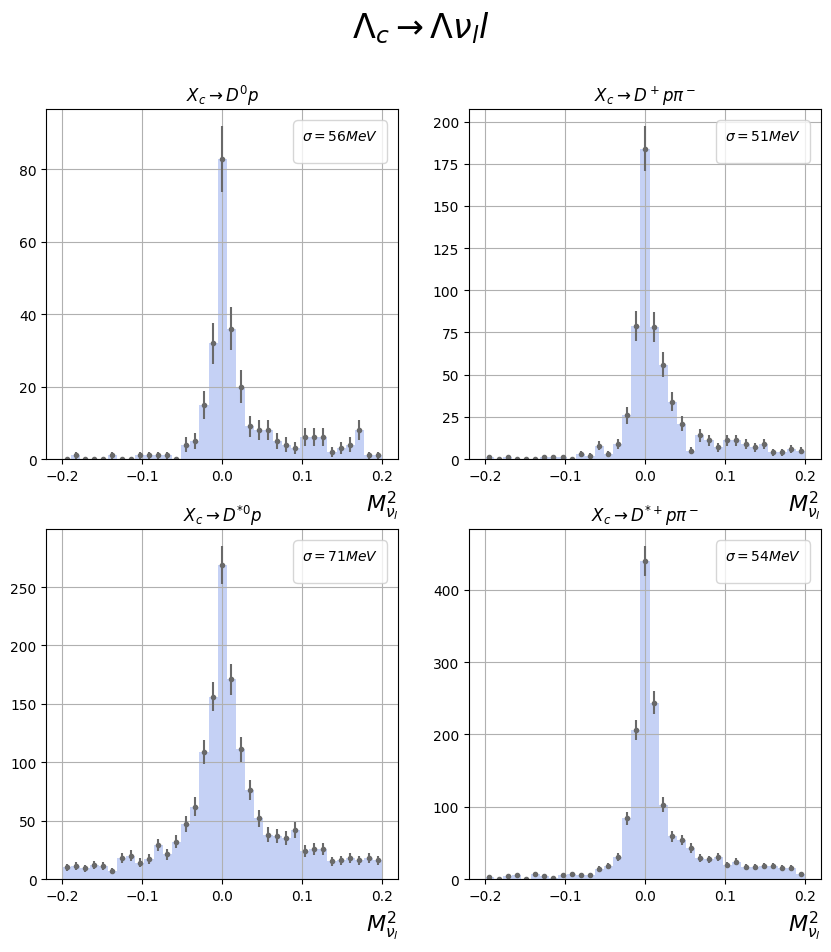

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 35

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) & (np.abs(mc.nrm2n) < 0.2)
    counts, bin_edges, _ = axs[i//n, i%n].hist(mc[(mc.chxc == i + 1) & mask].nrm2n, bins = nbins, range = (-0.2, +0.2), alpha = 0.3, color = "royalblue")
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
    axs[i//n, i%n].set_title(decay_mod_taging[i])
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')   & mas
    axs[i//n, i%n].legend(title=f'$\\sigma = {round(float(np.var(mc[(mc.chxc == i + 1) & mask].nrm2n)**0.5*1000))} MeV$', fontsize=16)

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fit_w_aft.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


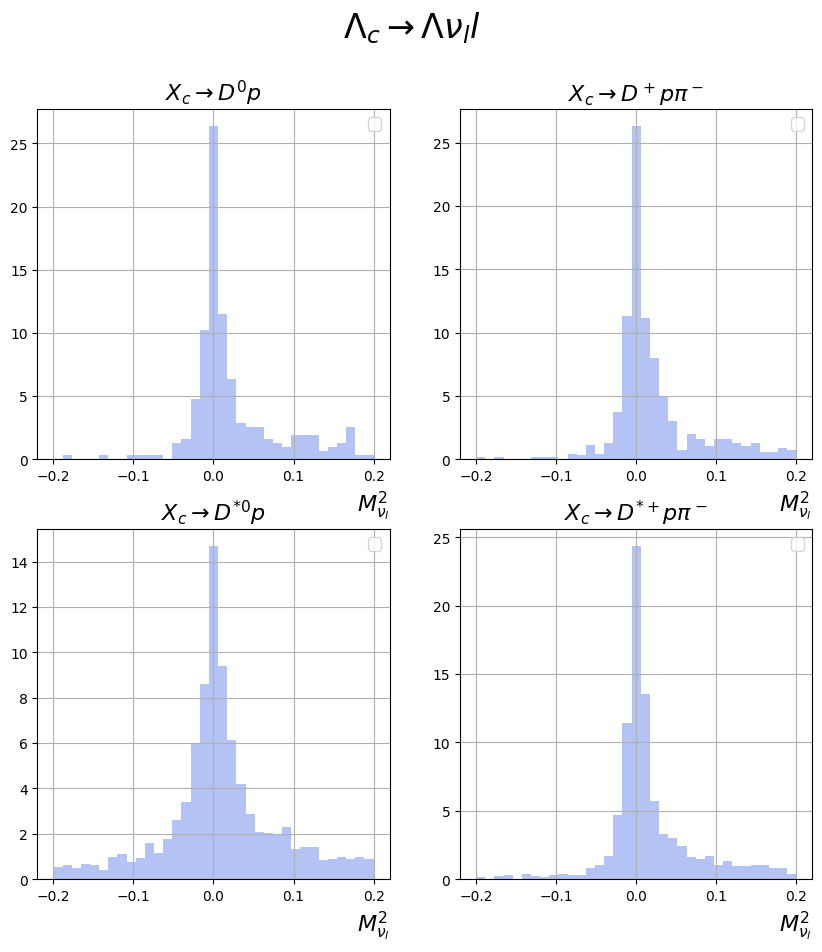

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 35

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl == 3) & (np.abs(mc.nrm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) &  (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i])
    dat = mc[(mc.chxc == i + 1) & (np.abs(mc.nrm2n) < 0.2) & mask]
    axs[i//n, i%n].hist(dat.nrm2n, bins = nbins, alpha = 0.4, color = "royalblue", range = (-0.2, +0.2), density = True)
    axs[i//n, i%n].hist(dat[(dat.tr_p == 1) & (dat.tr_ach == 1) & (dat.tr_lamc == 1)].nrm2n, bins = nbins, alpha = 0.4, density = True, color = "dimgrey", range = (-0.2, +0.2))
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')   & mas
    axs[i//n, i%n].legend(fontsize=12)

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//fit_w_both.png")

In [ ]:
continuum = lambda x, c0, c1, c2: c0*eval_chebyt(0, x) + c1*eval_chebyt(1, x) + c2*eval_chebyt(2, x)
sigmal_n = lambda x, A1, sigma1: A1*gaussian(x, 0, sigma1)
f_n = lambda x, A1, sigma1, c0, c1, c2: sigmal_n(x, A1, sigma1) + continuum(x, c0, c1,  c2)

126
100
269
104
62


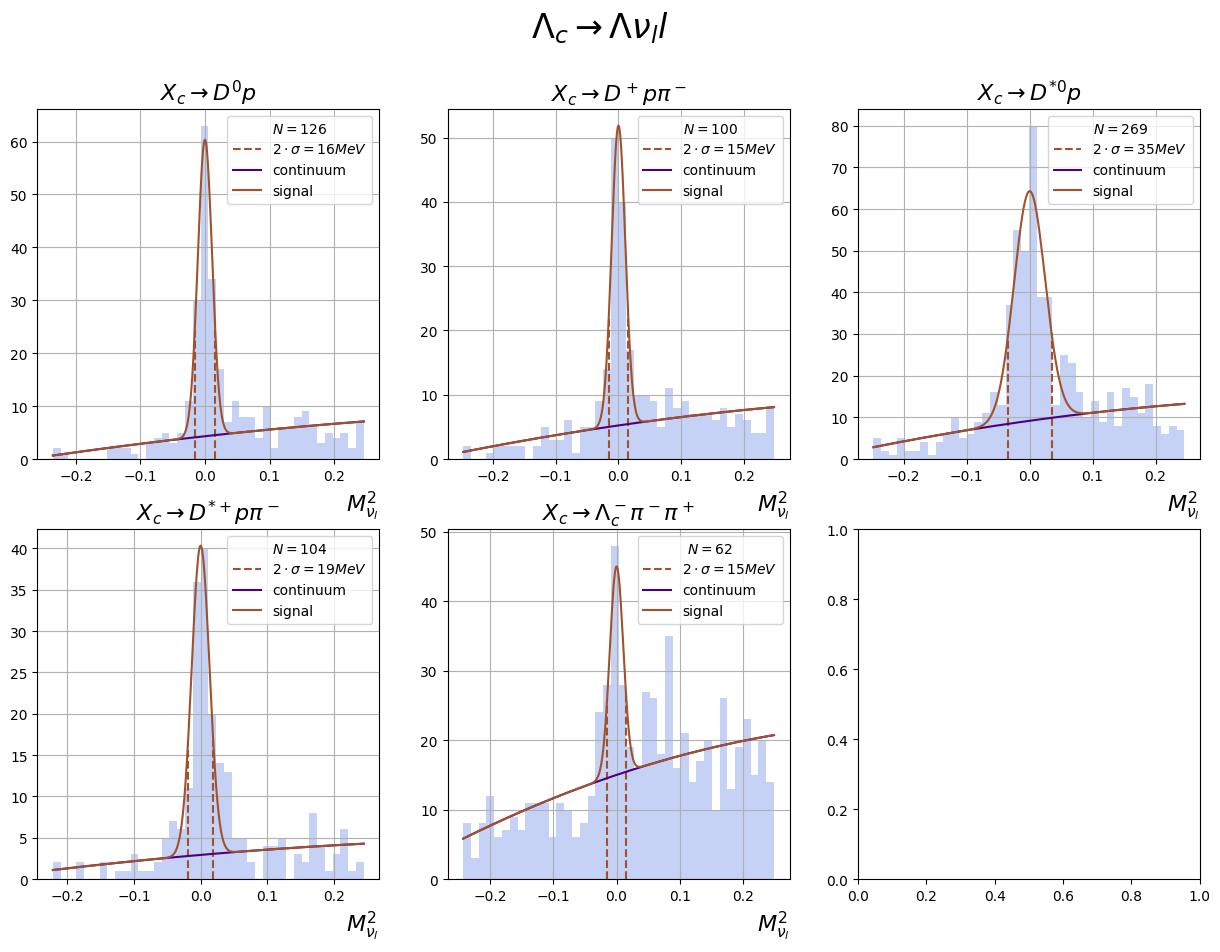

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 40
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
sig_n = list()
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) & (np.abs(mc.nrm2n) < 0.25)
    _ = mc[(mc.chxc == i + 1) & mask]
    norm = _.nrm2n.shape[0]

    counts, bin_edges, _ = axs[i//n, i%n].hist(_.nrm2n, bins = nbins, 
                            alpha = 0.3, color = "royalblue")

    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 500)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    args, covar = curve_fit(f_n, bin_centers, counts/norm, bounds = ([-np.inf, 0, 0, 0, -1], [np.inf, 0.05, 1, 1, 1]))

    xx = np.linspace(-3, 3, 50000)
    sig_n.append(args[1])
    s = 2*sig_n[-1]
    axs[i//n, i%n].vlines((-s,s), (0, 0), (f_n(-s, *args)*norm, f_n(s, *args)*norm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\cdot \\sigma = {round(s*1000)} MeV$")

    axs[i//n, i%n].plot(x, continuum(x, *args[-3:])*norm, color = 'indigo', label =  "continuum")
    axs[i//n, i%n].plot(x, f_n(x, *args)*norm, color = 'sienna', label = "signal")
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')

    N = np.sum(sigmal_n(bin_centers, *args[:2])*norm, dtype=int)
    axs[i//n, i%n].legend(title=f'$N = {N}$')
    print(N)
fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//count_nrm2n_lept.png")
if "mc" in fname:
    fig.savefig("..//Lam_c//data//count_nrm2n_mc.png")

In [ ]:
continuum = lambda x, c0, c1, c2: c0*eval_chebyt(0, x) + c1*eval_chebyt(1, x) + c2*eval_chebyt(2, x)
sigmal_n = lambda x, A1, sigma1: A1*gaussian(x, 0, sigma1)
f_n = lambda x, A1, sigma1, mu, c0, c1, c2: (sigmal_n(x, A1, sigma1) + continuum(x, c0, c1, c2)) * np.heaviside(-(x-mu), 1)

$X_c \to D^0 p$ 152
$X_c \to D^+ p \pi^- $ 156
$X_c \to D^{*0} p$ 329
$X_c \to D^{*+} p \pi^-$ 108
$X_c \to \Lambda_c^- \pi^- \pi^+$ 123
[0.007820541712490466, 0.007709247886032468, 0.017483345498215473, 0.00942932826794022, 0.007564345997453639]


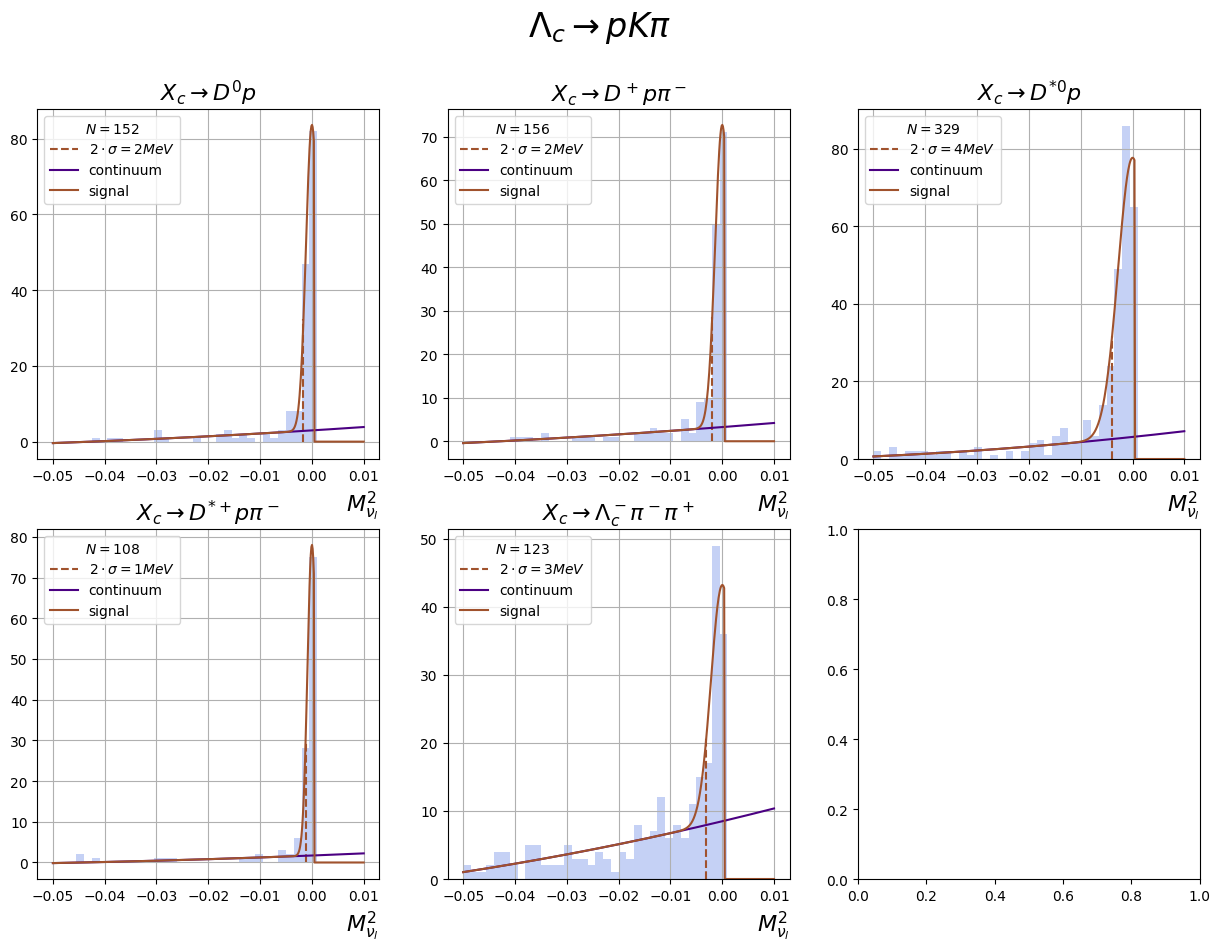

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 40
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl == 5)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_5[i]) & (mc.ml < 0) & (np.abs(mc.nrm2n) < 0.25)
    _ = mc[(mc.chxc == i + 1) & mask]
    norm = _.nrm2n.shape[0]

    counts, bin_edges, _ = axs[i//n, i%n].hist(_.nrm2n, bins = nbins,  range = (-0.05, 0.01),
                            alpha = 0.3, color = "royalblue")

    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 500)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    args, covar = curve_fit(f_n, bin_centers, counts/norm, bounds = ([-np.inf, 0, -0.001, 0, 0, -1], [np.inf, 0.05, 0.002, 1, 1, 1]))

    xx = np.linspace(-3, 3, 50000)
    s = 2*args[1]
    axs[i//n, i%n].vlines((-s,s), (0, 0), (f_n(-s, *args)*norm, f_n(s, *args)*norm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\cdot \\sigma = {round(s*1000)} MeV$")

    axs[i//n, i%n].plot(x, continuum(x, *args[-3:])*norm, color = 'indigo', label =  "continuum")
    axs[i//n, i%n].plot(x, f_n(x, *args)*norm, color = 'sienna', label = "signal")
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$M^2_{\\nu_l}$", fontsize=16, loc='right')

    N = np.sum(sigmal_n(bin_centers, *args[:2])*norm, dtype=int)
    print(decay_mod_taging[i], N)
    axs[i//n, i%n].legend(title=f'$N = {N}$')
print(sig_n)
fig.suptitle("$\\Lambda_c \\to p K \\pi$", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//count_nrm2n_pkpi.png")
if "mc" in fname:
    fig.savefig("..//Lam_c//data//count_nrm2n_mc.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


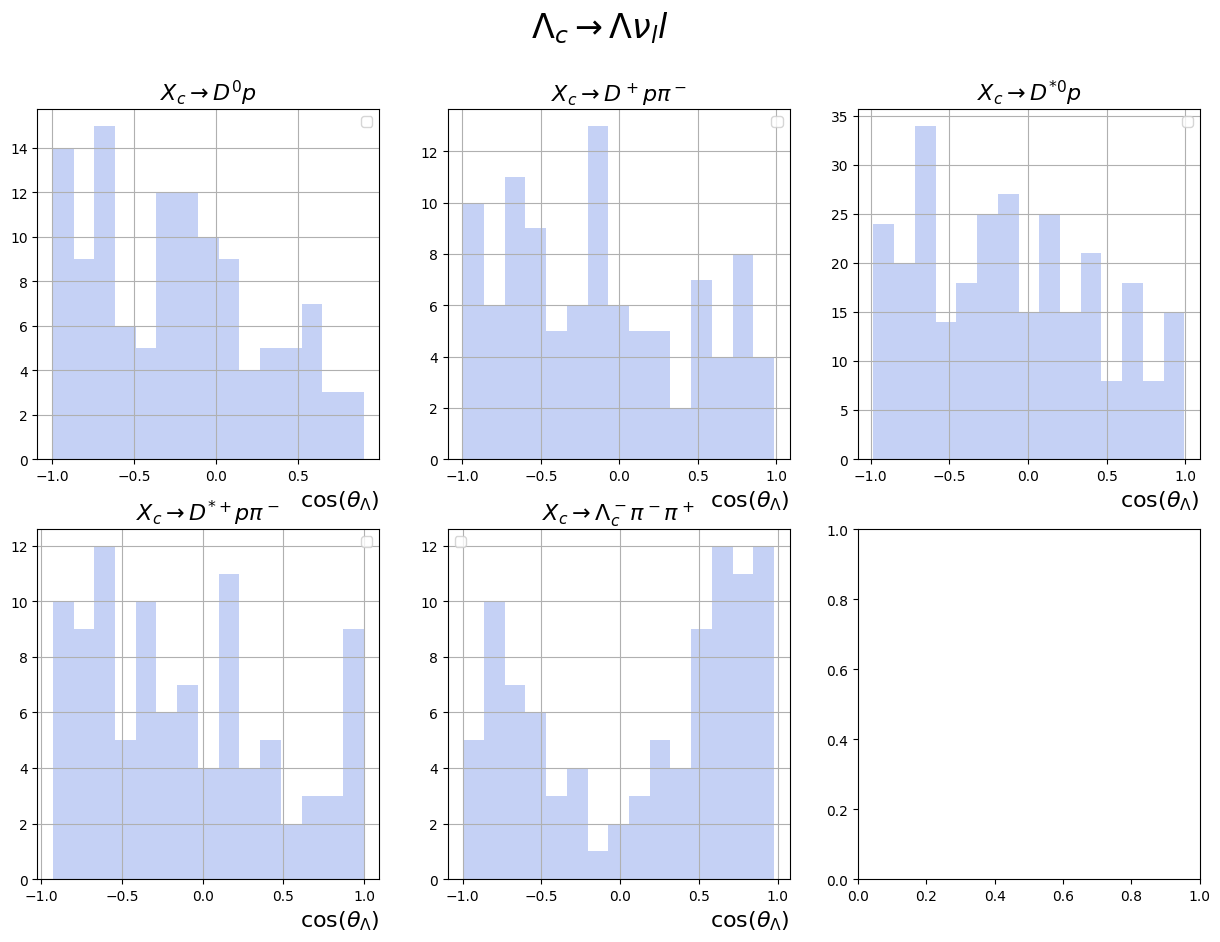

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 15

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2) & (mc.ml < 0) & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (np.abs(mc.nrm2n) < 2*sig_n[i])
    _ = mc[(mc.chxc == i + 1) & mask]

    axs[i//n, i%n].hist(np.cos(_.ang_lc_l), bins = nbins, alpha = 0.3, color = "royalblue")
    #axs[i//n, i%n].hist(np.cos(_.ang_lc_l), bins = nbins, alpha = 0.3, color = "dimgrey")
    #axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$\\cos(\\theta_{\\Lambda})$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')  
    axs[i//n, i%n].legend()

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//ang_lc_l.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


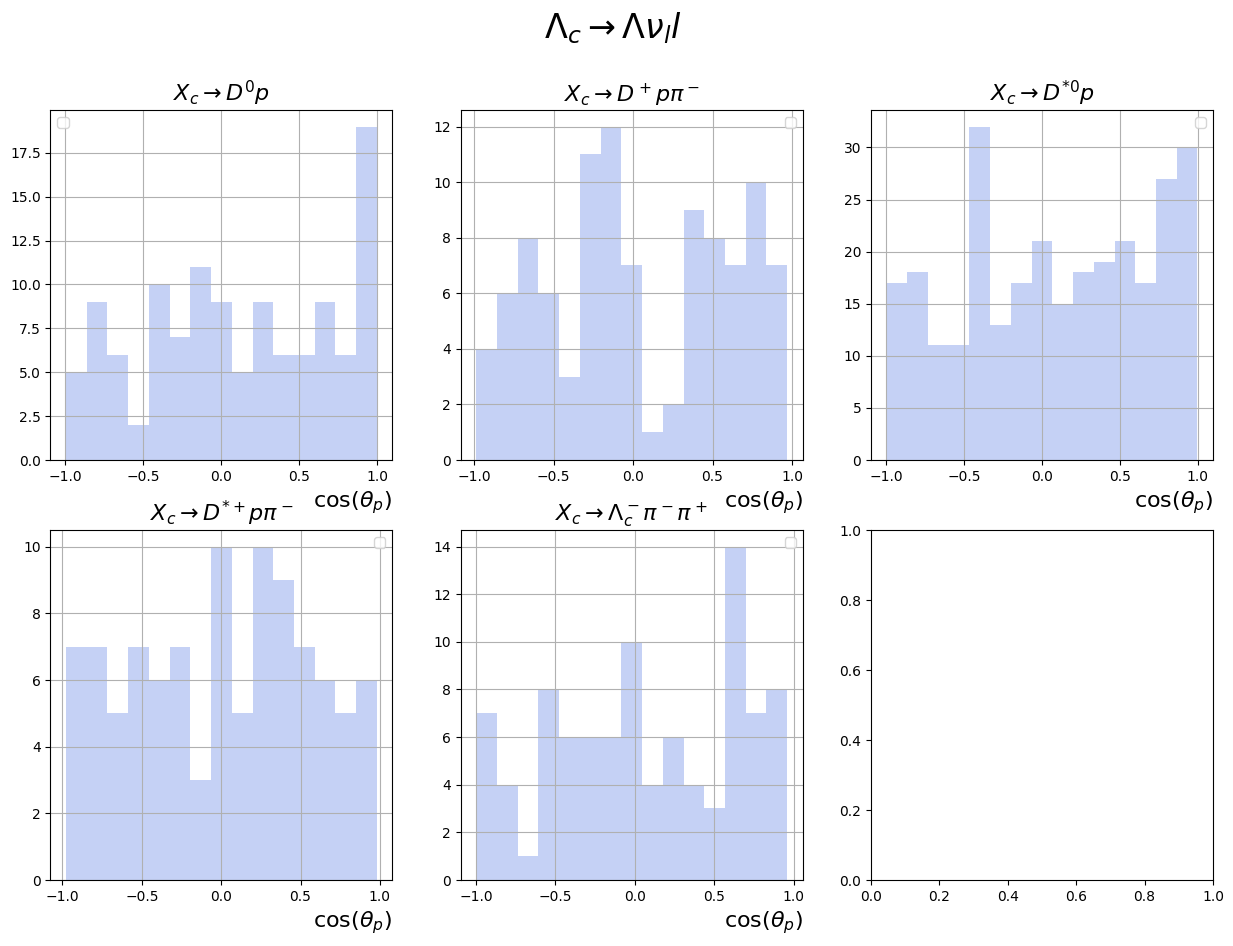

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 15

fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
for i in range(chxc):
    mask = (mc.chl <= 2)  & (np.abs(mc.rm2l - lamc_mass) < 2*sigmas_12[i]) & (mc.ml < 0) & (np.abs(mc.nrm2n) < 0.25) & (np.abs(mc.nrm2n) < 2*sig_n[i])
    _ = mc[(mc.chxc == i + 1) & mask]

    counts, bin_edges, _ = axs[i//n, i%n].hist(np.cos(_.ang_l_p), bins = nbins, alpha = 0.3, color = "royalblue")
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    #axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=16)
    axs[i//n, i%n].grid(True)
    axs[i//n, i%n].set_xlabel("$\\cos(\\theta_{p})$", fontsize=16, loc='right')
    #axs[i//n, i%n].set_ylabel(yl, fontsize=14, loc='top')  
    axs[i//n, i%n].legend()

fig.suptitle("$\\Lambda_c \\to \\Lambda \\nu_l l $", fontsize=24)
plt.show()
if "real" in fname:
    fig.savefig("..//Lam_c//data//ang_l_p.png")